![logo cunef](https://www.cunef.edu/wp-content/uploads/2021/06/cunef-logo.svg)
# TRABAJO FINAL ML

## Análisis Exploratorio de los Datos

**Victor Fernandez-Jimenez & Hugo Pasqual del Pobil**

CUNEF 2021-2022

Machine Learning

### Objetivos:

¿Qué tipos de vehículos (modelos, antigüedad, etc.) y conductores son más propensos a tener accidentes (acción correctiva en prima)?

¿Qué tipos de vehículos (modelos, antigüedad, etc.) y conductores son menos propensos a tener accidentes (descuento en prima)?

¿Qué es lo que más contribuye a que existan fallecimientos en un accidente?

Dado un accidente, ¿se puede generar un modelo que prediga si habrá fallecimientos o no? ¿Si se va a necesitar tratamiento médico o no? Las aseguradoras tienen que inmovilizar capital para pagar estas casuísticas. 

Plus: complementar con datos abiertos de clima (aunque Canadá es muy grande) y de otra tipología, ¿hay algún tipo de relación con temperaturas medias, precipitación media del día/mes, nieve...? ¿a más días festivos o de vacaciones, más accidentes? etc.

### Datos:

Se utiliza un data ser obtenido de https://www.kaggle.com/tbsteal/canadian-car-accidents-19942014?select=drivingLegend.pdf

La base de datos nacional de colisiones de Transport Canada (NCDB) contiene
datos sobre todas las colisiones de vehículos motorizados notificables en Canadá que las
provincias y territorios proporcionan cada año.

El año 2014 vio una disminución en el número de muertes, graves
lesiones y lesiones totales; de hecho, 2014 marcó los conteos más bajos
para los tres grupos de víctimas ya que estos datos fueron
recopilada por Transport Canada a principios de la década de 1970.
    
  1. En 2014, el número de víctimas mortales de vehículos de motor fue de 1.834;
  6,0% menos que en 2013 (1.951).
    
  2. Continuó la tendencia a la baja de lesiones graves, disminuyendo
  a 9,647 en 2014; 9,5% menos que en 2013 (10.663).
    
  3. El número de muertes por cada 100.000 habitantes
  fue de 5,2 en 2014, frente a 5,5 en 2013.
    
  4. El número de muertes por mil millones de kilómetros recorridos por vehículos
  fue de 5,1 en 2014; el más bajo registrado.

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import warnings
import statistics
from _Funciones import barplot_missings, limpiar_vacios, barplot_fatality, heatmap_collision

warnings.filterwarnings("ignore")

# Opciones de viasualización
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

### Extracción de los datos

Importamos los datos y consultamos y comprobamos que se han importado correctamente.
Seguidamente, visualizamos los datos.

In [2]:
df = pd.read_csv('NCDB_1999_to_2014_1.csv')
print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [3]:
df

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
0,1999,1,1,20,2,02,34,UU,1,5,3,03,01,06,1990,01,M,41,11,1,UU,1
1,1999,1,1,20,2,02,34,UU,1,5,3,03,02,01,1987,01,M,19,11,1,UU,1
2,1999,1,1,20,2,02,34,UU,1,5,3,03,02,01,1987,02,F,20,13,2,02,2
3,1999,1,1,08,2,01,01,UU,5,3,6,18,01,01,1986,01,M,46,11,1,UU,1
4,1999,1,1,08,2,01,01,UU,5,3,6,18,99,NN,NNNN,01,M,05,99,2,UU,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5860400,2014,UU,U,UU,2,UU,UU,01,U,U,U,UU,13,07,UUUU,01,M,24,11,1,NN,1
5860401,2014,UU,U,23,2,01,06,05,1,1,U,18,1,14,2006,01,M,29,96,2,09,5
5860402,2014,UU,U,14,2,01,02,01,1,5,4,18,1,01,2006,01,F,UU,11,2,01,1
5860403,2014,UU,U,22,1,01,06,01,2,4,Q,18,1,22,UUUU,01,M,67,12,3,01,U


Cambiamos los nombres de nuestras variables a minúsculas para su mejor uso.

In [4]:
df.columns = df.columns.map(lambda x: x[:].lower())

### Transformación variable tiempo

Los datos importados no incluyen una fecha completa o índice en formato fecha. Con las variables de año y mes creamos una nueva variable 'date' y la seleccionamos como índice para transformar el dataframe en una serie temporal de accidentes de tráfico.

In [5]:
df.c_mnth[df.c_mnth=='UU'] = statistics.mode(df.c_mnth)

In [6]:
df['date'] = pd.DatetimeIndex(df['c_year'].map(str) + '-' + df['c_mnth'].map(str))

### Transformación de valores desconocidos

En primer lugar, vamos a consultar el número de valores desconocidos para cada columna de nuestro dataframe:

In [7]:
df_unknown = pd.DataFrame(df.columns.T, columns=['column'])

In [8]:
lista_nas = ['U', 'X', 'UU', 'XX', 'UUUU', 'XXXX']

unknown_values = []
unknown_pct = []

for i in df.columns:
    unknown_count = 0
    pct = 0
    if len(str(df[i][0]))==1:
        unknown_count = df[i][df[i].isin(lista_nas[0:1])].count()
    elif len(str(df[i][0]))==2:
        unknown_count = df[i][df[i].isin(lista_nas[2:3])].count()
    elif len(str(df[i][0]))==4:
        unknown_count = df[i][df[i].isin(lista_nas[4:5])].count()
    
    pct = unknown_count / len(df[i]) * 100
    unknown_values.append(unknown_count)
    unknown_pct.append(pct)

df_unknown['count'] = unknown_values
df_unknown['pct'] = unknown_pct
df_unknown.sort_values(by='count',ascending=False)

,column,count,pct
20,p_safe,615188,10.497363
7,c_rcfg,504648,8.611145
10,c_raln,434710,7.417747
17,p_age,377140,6.435391
14,v_year,324122,5.530710
16,p_sex,234954,4.009177
11,c_traf,223483,3.813440
6,c_conf,179019,3.054721
21,p_user,175586,2.996141
8,c_wthr,87975,1.501176


Por lo general, las variables con más valores desconocidos o no provistos, son variables que desconocemos en el momento de un accidente. En el caso de estas variables, no se realizará ninguna transformación de los valores faltantes. En concreto, estas variables son:
* p_safe
* p_age
* v_year
* p_sex
* c_traf
* p_isev
* c_rsur
* v_id
* p_id

Las variables cuyos valores faltantes tenemos que sustituir son:
* c_raln
* c_rcfg
* c_wday
* c_conf
* c_hour
* c_vehs
* c_wthr
* v_type
* p_psn
* p_user

Para estas variables a transformar, vamos a ver mediante un gráfico de barras como se distribuyen sus valores. En caso de que el valor más frecuente difiera considerablemente del siguiente más frecuente, se sustituirán los valores faltantes por la moda.

lista_nas_q = ['U', 'Q', 'X', 'UU', 'QQ', 'XX', 'NN', 'UUUU', 'QQQQ', 'XXXX']



def barplot_missings(variable):
    dataframe = df[~df[variable].isin(lista_nas_q)]
    dataframe[variable] = pd.to_numeric(dataframe[variable])
    grouped_total = dataframe[variable].value_counts()
    pct_diff = (grouped_total.iloc[0] / grouped_total.iloc[1] * 100) - 100
    print('Diferencia porcentual entre los dos valores más comunes de ' + variable + ': ' + str(pct_diff) + '%')
    grouped_total.plot(kind='bar',figsize=(15,5), color='#F58233', title = variable)
    plt.show()

Diferencia porcentual entre los dos valores más comunes de c_raln: 612.7021959676383%


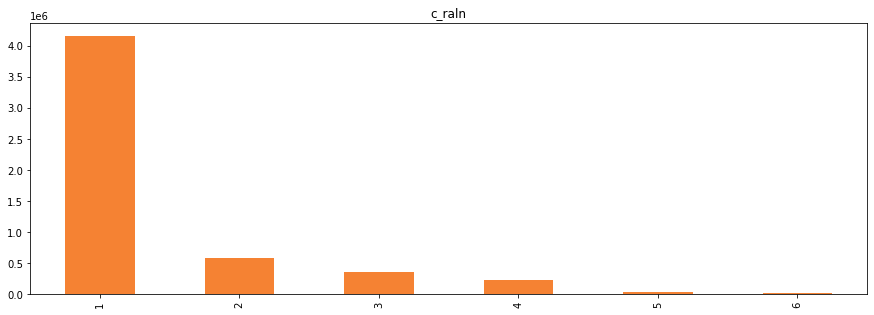

Diferencia porcentual entre los dos valores más comunes de c_rcfg: 32.08618355722368%


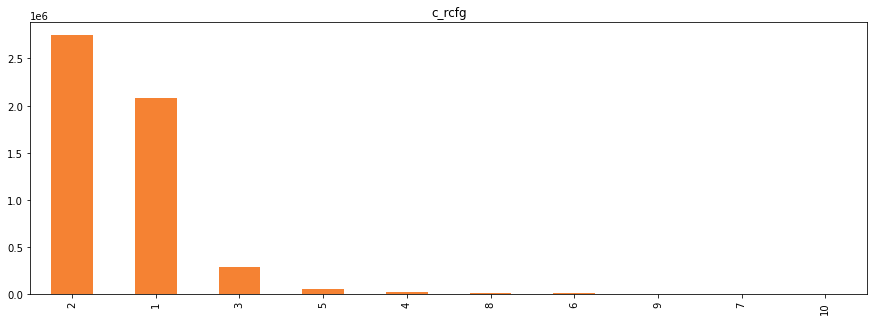

Diferencia porcentual entre los dos valores más comunes de c_wday: 14.95677011405698%


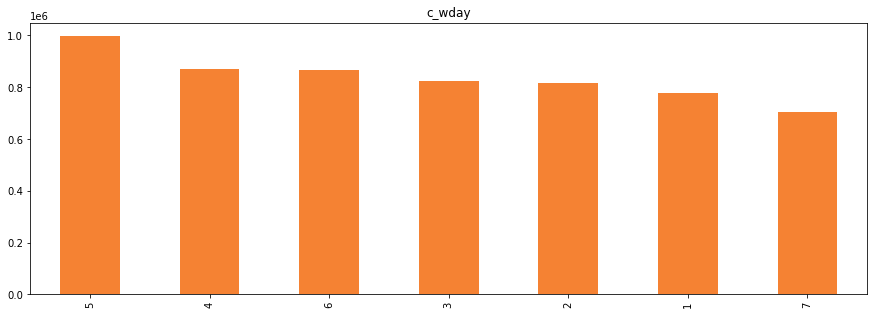

Diferencia porcentual entre los dos valores más comunes de c_conf: 104.01038013261967%


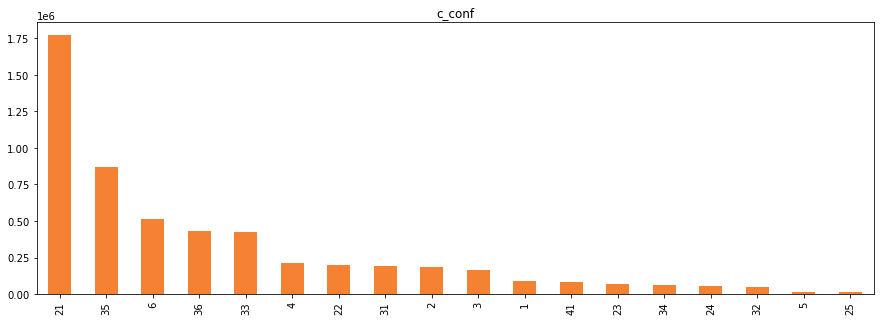

Diferencia porcentual entre los dos valores más comunes de c_hour: 3.8780255216382074%


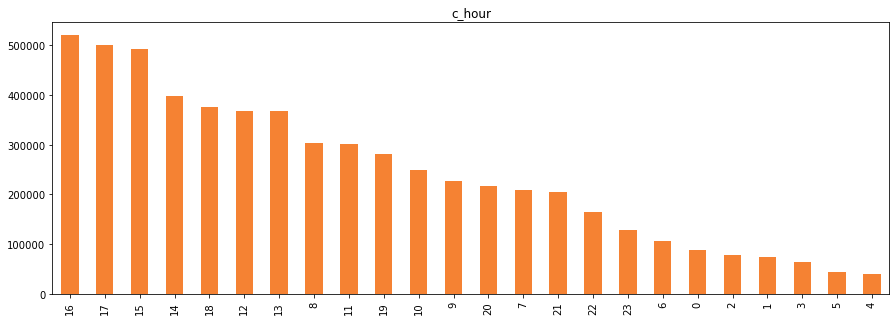

Diferencia porcentual entre los dos valores más comunes de c_vehs: 189.35562136196847%


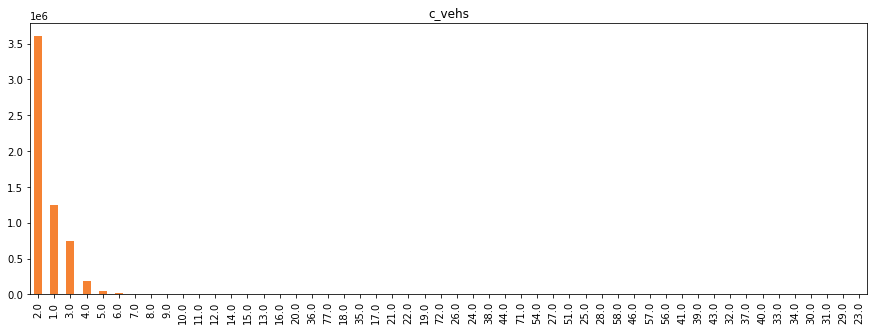

Diferencia porcentual entre los dos valores más comunes de c_wthr: 578.833972537011%


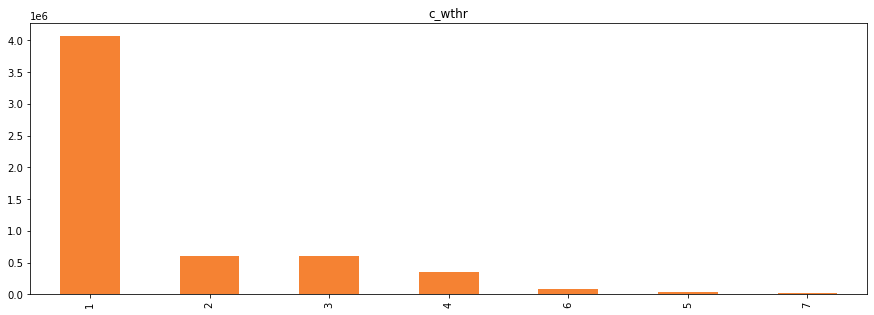

Diferencia porcentual entre los dos valores más comunes de v_type: 2650.79063883618%


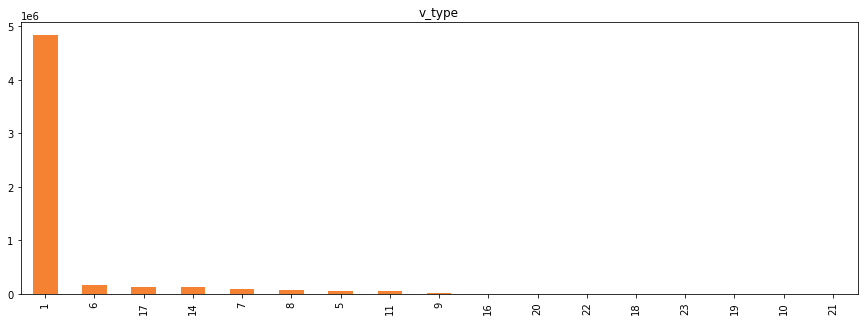

Diferencia porcentual entre los dos valores más comunes de p_psn: 343.85925244252905%


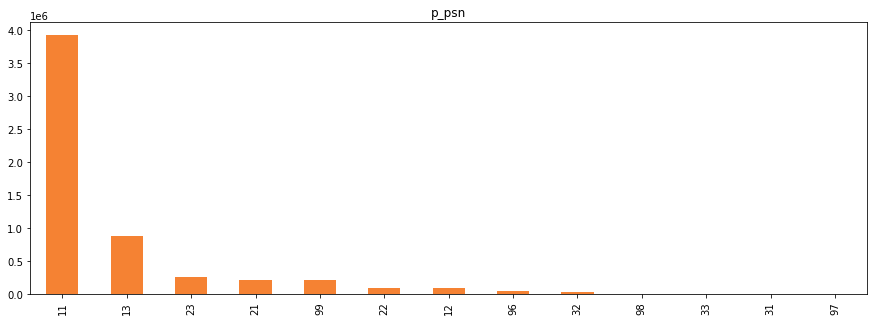

Diferencia porcentual entre los dos valores más comunes de p_user: 134.38784021155482%


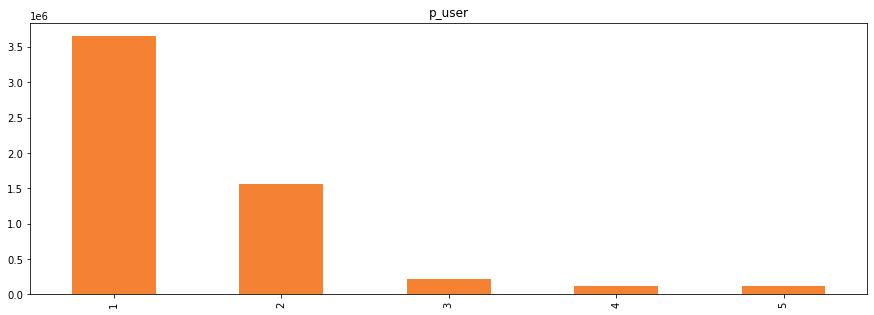

In [9]:
missing_trf_col = ['c_raln', 'c_rcfg', 'c_wday', 'c_conf', 'c_hour', 'c_vehs', 'c_wthr', 'v_type', 'p_psn', 'p_user']

for i in missing_trf_col:
    barplot_missings(df, i)

Mediante los gráficos anteriores, se puede observar una diferencia significativa entre los dos valores más comunes (más de un 150% de diferencia entre ellos) en las siguientes variables:
* c_raln
* c_vehs
* c_wthr
* v_type
* p_psn

En estas variables, los valores desconocidos lo sustituiremos directamente por la moda.\
En el resto de variables, se realizará una regresión para asignar los valores.

In [10]:
df['p_age'].unique()

array(['41', '19', '20', '46', '05', '28', '21', 'UU', '61', '56', '34',
       '22', '30', '49', '32', '31', '68', '08', '45', '17', '33', '82',
       '39', '37', '55', '38', '43', '35', '23', '25', '65', '44', '36',
       '70', '50', '40', '27', '26', '15', '53', '16', '13', '14', '12',
       '18', '77', '86', '42', '24', '47', '62', '06', '57', '83', '74',
       '67', '51', '29', '01', '02', '54', '71', '10', '79', '63', '58',
       '48', '60', '07', '64', '75', '52', '85', '93', '92', '69', '72',
       '11', '59', '09', '66', '76', '73', '04', '78', '80', '84', '03',
       '81', '89', '87', '88', '90', 'NN', '91', '95', '97', '94', '99',
       '98', '96'], dtype=object)

Sustituimos los valores no conocidos por NAs para seguidamente eliminarlos y utilizar datos completos. La reducción de las dimensiones de los datos no deriva en una varianza significativa en las conclusiones hayadas del análisis exploratorio.

In [11]:
cols_mode = ['c_raln', 'c_vehs', 'c_wthr', 'v_type', 'p_psn',\
             'c_mnth', 'c_wday', 'c_year', 'c_hour', 'p_age']
df = limpiar_vacios(df, cols_mode)

### Leyenda de variables explicada
#### Variables del accidente
**C_YEAR:** Año en el que se produce el accidente. \
**C_MONTH:** Mes en el que se produce el accidente. Puede ser relevante debido a la existencia de estacionalidad. \
**C_WEEKDAY:** Día de la semana en el que se produce el accidente. Puede ser relevante debido a la existencia de estacionalidad. \
**C_HOUR:** Hora del día en el que se produce el accidente. \
**C_SEV:** Indica si se ha producido al menos un fallecimiento en el accidente. \
**C_VEHS:** Número de vehículos involucrados en el accidente. \
**C_CONF:** Variable categórica que describe el tipo de colisión. Está formada por números de dos cifras, siendo la primera cifra 0 si solo hay un vehículo en movimiento involucrado, 2 si hay dos vehículos en movimiento en la misma dirección, 3 si hay dos vehículos en movimiento en direcciones contrarias, 4 si hay un vehículo en movimiento y otro estacionado, QQ en otros casos, UU si es desconocido, y XX si no se provee dicho dato. \
**C_RCFG:** Variable categórica que describe el tipo de vía en la que se produce el accidente. UU si es desconocido, y XX si no se provee dicho dato. \
**C_WTHR:** Variable categórica que describe las condiciones meteorológicas en el momento del accidente. Q en otros casos, U si es desconocido, y X si no se provee dicho dato. \
**C_RSUR:** Variable categórica que describe elementos en la calzada que pueden haber influido en el accidente, como manchas de aceite, agua, nieve... Q en otros casos, U si es desconocido, y X si no se provee dicho dato. \
**C_RALN:** Variable categórica que describe el tramo en el que se produce el accidente, como desniveles, curvas, etc. Q en otros casos, U si es desconocido, y X si no se provee dicho dato. \
**C_TRAF:** Variable categórica que describe las señales de tráfico en el lugar del accidente. QQ en otros casos, UU si es desconocido, y XX si no se provee dicho dato. 

#### Variables del vehículo
**V_ID:** Identificador asignado al vehículo al que pertenece la persona. 99 en caso de ser peatón, y UU si es desconocido. \
**V_TYPE:** Variable categórica que describe el tipo de vehículo. NN si no aplica, QQ en otros casos, UU si es desconocido, y XX si no se provee dicho dato. \
**V_YEAR:** Año de fabricación del vehículo. NNNN si no aplica, UUUU si es desconocido, y XXXX si no se provee dicho dato. 

#### Variables de la persona
**P_ID:** Identificador asignado a la persona involucrada. NN si no aplica, y UU si es desconocido. \
**P_SEX:** Variable categórica que describe el sexo de la persona involucrada. N si no aplica, U si es desconocido, y X si no se provee dicho dato. \
**P_AGE:** Edad de la persona involucrada. NN si no aplica, UU si es desconocido, y XX si no se provee dicho dato. \
**P_PSN:** Variable categórica que describe la posición en el vehículo del pasajero en el momento del accidente. NN si no aplica, QQ en otros casos, UU si es desconocido, y XX si no se provee dicho dato. \
**P_ISEV:** Variable categórica que describe los daños sufridos por la persona involucrada en el accidente. N si no aplica, U si es desconocido, y X si no se provee dicho dato. \
**P_SAFE:** Variable categórica que describe los sistemas de seguridad que la persona utilizaba en el momento del accidente. NN si no aplica, QQ en otros casos, UU si es desconocido, y XX si no se provee dicho dato. \
**P_USER:** Variable categórica que describe el rol de la persona en el accidente. U si es desconocido.

Comprobamos las dimentiones y las variables de nuestros datos:

In [12]:
print(df.shape)
print('')
print(df.columns)

(5860405, 23)

Index(['c_year', 'c_mnth', 'c_wday', 'c_hour', 'c_sev', 'c_vehs', 'c_conf',
       'c_rcfg', 'c_wthr', 'c_rsur', 'c_raln', 'c_traf', 'v_id', 'v_type',
       'v_year', 'p_id', 'p_sex', 'p_age', 'p_psn', 'p_isev', 'p_safe',
       'p_user', 'date'],
      dtype='object')


#### Diccionario con el tipo de datos de cada columna

In [13]:
df.dtypes.to_dict()

{'c_year': dtype('int64'),
 'c_mnth': dtype('O'),
 'c_wday': dtype('O'),
 'c_hour': dtype('O'),
 'c_sev': dtype('int64'),
 'c_vehs': dtype('O'),
 'c_conf': dtype('O'),
 'c_rcfg': dtype('O'),
 'c_wthr': dtype('O'),
 'c_rsur': dtype('O'),
 'c_raln': dtype('O'),
 'c_traf': dtype('O'),
 'v_id': dtype('O'),
 'v_type': dtype('O'),
 'v_year': dtype('O'),
 'p_id': dtype('O'),
 'p_sex': dtype('O'),
 'p_age': dtype('O'),
 'p_psn': dtype('O'),
 'p_isev': dtype('O'),
 'p_safe': dtype('O'),
 'p_user': dtype('O'),
 'date': dtype('<M8[ns]')}

Aplicamos un primer filtro para la edad de los conductores, excluimos los valores no conocidos. Y comprobamos de nuevo la dimensión de los datos.

In [14]:
df = df[df['p_age'].str.contains('[0-9]')]

In [15]:
df.shape

(5465249, 23)

Creamos una copia de los datos para no tener que importar los datos cada vez que se quiere reiniciar el proceso de análisis de la tabla completa y asignamos la variable de 'date' sintética como índice.

In [16]:
df_2 = df.copy()

df_2['c_wday'] = pd.to_numeric(df_2['c_wday'])
df_2['c_mnth'] = pd.to_numeric(df_2['c_mnth'])
df_2['c_hour'] = pd.to_numeric(df_2['c_hour'])
df_2['c_year'] = pd.to_numeric(df_2['c_year'])
df_2['p_age'] = pd.to_numeric(df_2['p_age'])

df_2[['c_rcfg','c_wthr','c_rsur','c_traf']] =\
        df_2[['c_rcfg','c_wthr','c_rsur','c_traf']].replace('[^0-9]+',np.nan,regex=True)

df_2.dropna(axis=0,subset=['c_rcfg','c_wthr','c_rsur','c_traf'],inplace=True)

df_2 = df_2.set_index('date')

## 1. Severidad a lo largo del tiempo

La tendencia de la severidad de los accidentes decrece con el tiempo y tiene un patron de estacionalidad muy pronunciado. Se observa que durante la mitad del año incrementan los accidentes y disminuyen durante los 3 primeros meses del año.

In [17]:
df_2.shape

(4585469, 22)

In [18]:
df['c_sev'].value_counts()

2    5370705
1      94544
Name: c_sev, dtype: int64

**1.1 Tendencia en el periodo y identificación de componente estacional:**

Primer análisis de la mortalidad de los accidentes de todos los datos y visualización de la misma.

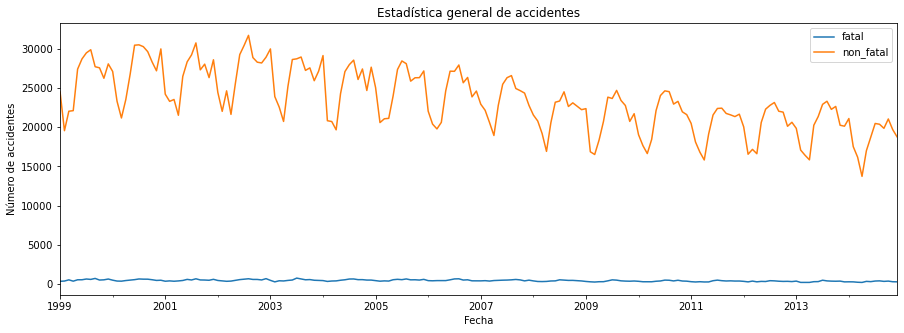

In [19]:
df_2['fatal']=np.where(df_2['c_sev']==1,1,0)
df_2['non_fatal']=np.where(df_2['c_sev']==2,1,0)

df_sev = df_2.groupby('date')['fatal','non_fatal'].sum()

plot1 = df_sev.plot(figsize=(15,5),title='Estadística general de accidentes')
plot1.set_xlabel("Fecha")
plot1.set_ylabel("Número de accidentes");

**1.2 Correlación entre numero total de accidentes y accidentes mortales**

Existe una alta correlación entre los accidentes mortales y los accidentes no mortales. Correlación positiva fuerte.

Normalizamos los datos para compararlos y poder observar componente estacional y correlación

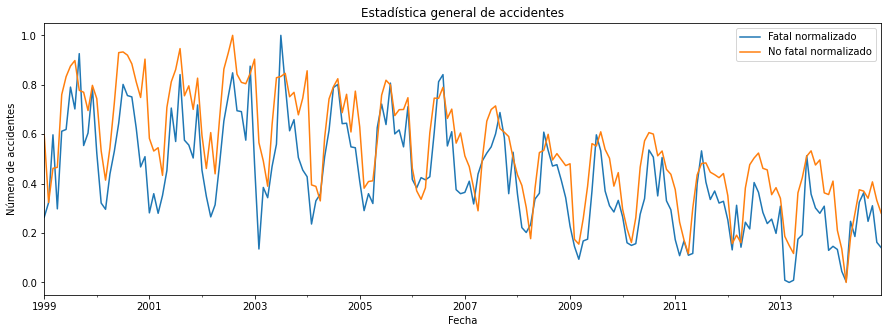

In [20]:
df_sev_norm = df_sev.copy()
df_sev_norm['Fatal normalizado']= ((df_sev_norm['fatal']-min(df_sev_norm['fatal']))/\
                                   (max(df_sev_norm['fatal'])-min(df_sev_norm['fatal'])))

df_sev_norm['No fatal normalizado']= ((df_sev_norm['non_fatal']-min(df_sev_norm['non_fatal']))/\
                                 (max(df_sev_norm['non_fatal'])-min(df_sev_norm['non_fatal'])))
df_sev_norm = df_sev_norm.drop(['fatal','non_fatal'], axis=1)

plot1 = df_sev_norm.plot(figsize=(15,5),title='Estadística general de accidentes')
plot1.set_xlabel("Fecha")
plot1.set_ylabel("Número de accidentes");

Confirmamos la asunción de que existe estacionalidad.

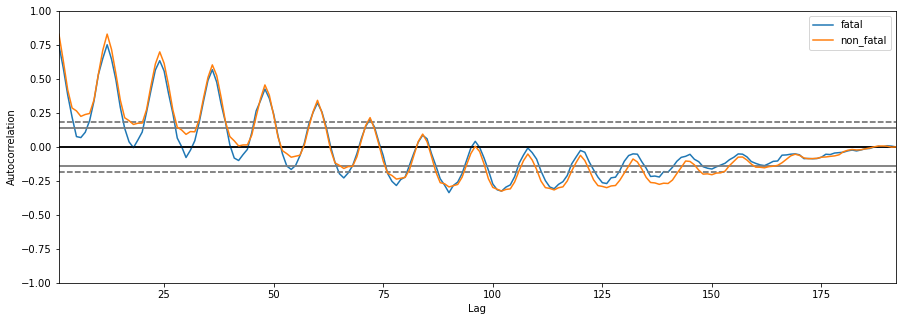

In [21]:
plt.figure(figsize=(15,5))
for c in df_sev.columns:
    autocorrelation_plot(df_sev[c],label=c);

Correlación entre mortalidad de los accidentes y visualización:

              fatal  non_fatal
fatal      1.000000   0.872705
non_fatal  0.872705   1.000000


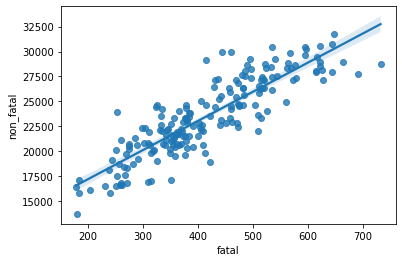

In [22]:
corr = df_sev.corr()
print(corr)
sns.regplot('fatal', 'non_fatal', data=df_sev);

## 2. Análisis de riesgo de accidente según mes, día de la semana y hora

El mayor riesgo de accidente es el viernes y el menor el Domingo.\
El periodo de horas con mas riesgo de accidente es de 3pm a 5pm. Durante la noche hay menos riesgo de accidente.

**Mes:**

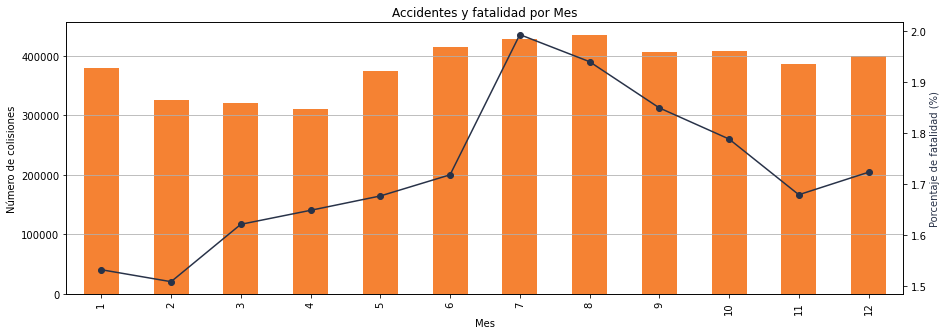

In [23]:
barplot_fatality(df_2, 'c_mnth', 'Mes')

**Semana:**

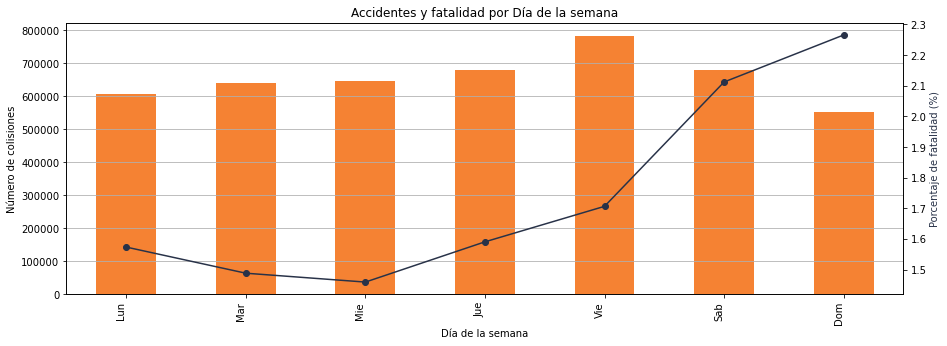

In [24]:
weekdays = ['Lun', 'Mar', 'Mie', 'Jue', 'Vie', 'Sab', 'Dom']
barplot_fatality(df_2, 'c_wday', 'Día de la semana', weekdays)

**Hora:**

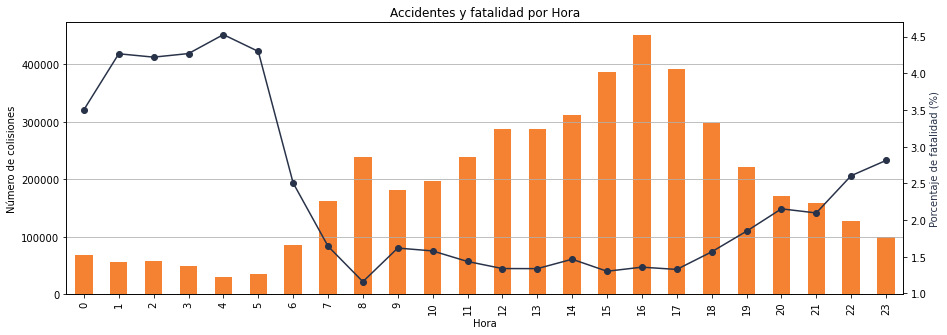

In [25]:
barplot_fatality(df_2, 'c_hour', 'Hora')

## 3. Análisis de riesgo de accidente según tipo de vía

### 3.1 Configuración de la vía

Observamos que la mayoría de los accidentes ocurren en 'Mid-Block' e intersecciones. El porcentage de mortalidad es alto en los accidentes con 'passing' o 'climbing lane' de 12%.

**Passing lane** = Carril de adelantamiento \
**Climbing lane** = Carril para vahículos pesados en pendientes

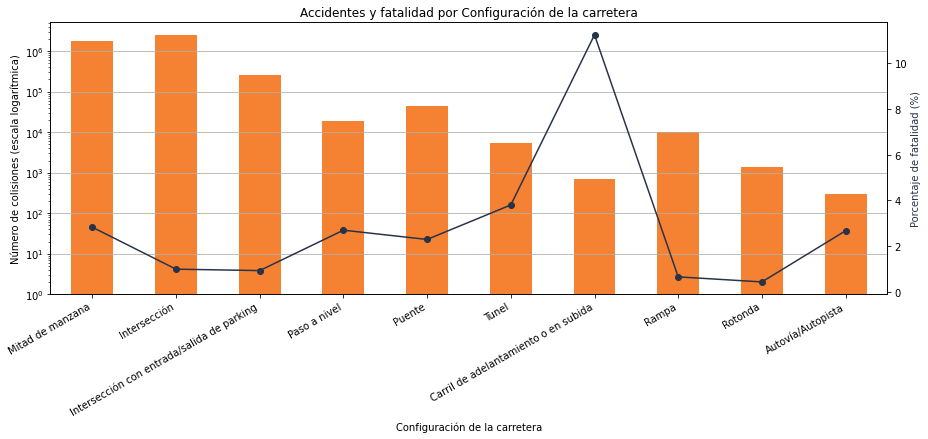

In [26]:
rcfg_type = ['Mitad de manzana','Intersección','Intersección con entrada/salida de parking',
            'Paso a nivel','Puente','Tunel','Carril de adelantamiento o en subida',
             'Rampa','Rotonda','Autovía/Autopista']
barplot_fatality(df_2, 'c_rcfg', 'Configuración de la carretera', rcfg_type)

### 3.2 Clima

La mayoría de los accidentes ocurren con cielos despejados y soleados. Aunque el porcetnage de mortalidad es mas alto cuando la visibilidad se reduce (niebla y viento fuerte). La tasa de mortalidad con las condiciones anteriores es del 4% aprox.

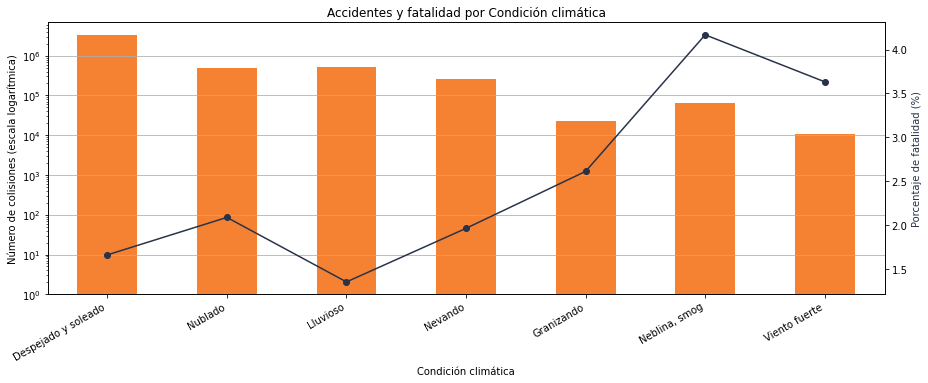

In [27]:
wthr_type = ['Despejado y soleado','Nublado','Lluvioso','Nevando','Granizando','Neblina, smog',
            'Viento fuerte']
barplot_fatality(df_2, 'c_wthr', 'Condición climática', wthr_type)

### 3.3 Superficie de la vía

Mientras que la mayoría de los accidentes ocurren en superficies secas y normales. La tasa de mortalidad es mayor en terreno arenoso, sucio o con barro. El porcentage se eleva al 4,5%. Los vehículos pierden tracción y es máscomplicado controlarlo, lo cual puede resultar en caidas por precipicios y collisiones con otros vehículos y objetos. 

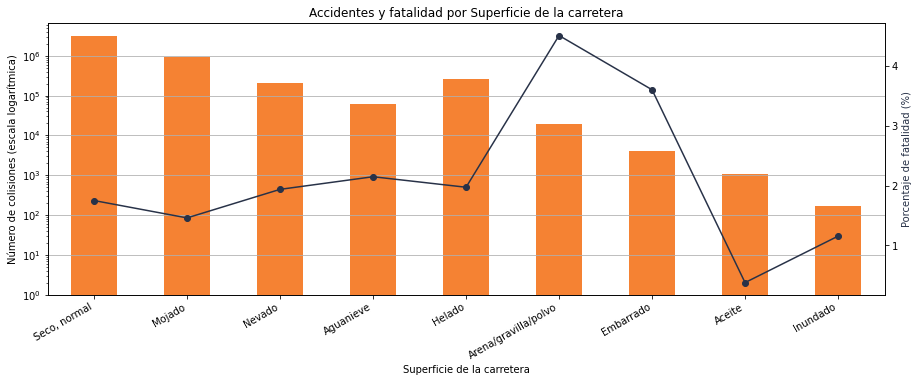

In [28]:
rsur_type = ['Seco, normal','Mojado','Nevado','Aguanieve','Helado',
             'Arena/gravilla/polvo','Embarrado','Aceite','Inundado']
barplot_fatality(df_2, 'c_rsur', 'Superficie de la carretera', rsur_type)

### 3.4 Control de tráfico

La mayoría de los accidentes ocurren cuando las señales de tráfico estan operativas y cuando no hay control de tráfico presente.\
La tasa mas alta de mortalidad ocurre cruzando las vias del tren. La tasa es alta también en zonas de baja velocidad, similares al 7%y 8% respectivamente.

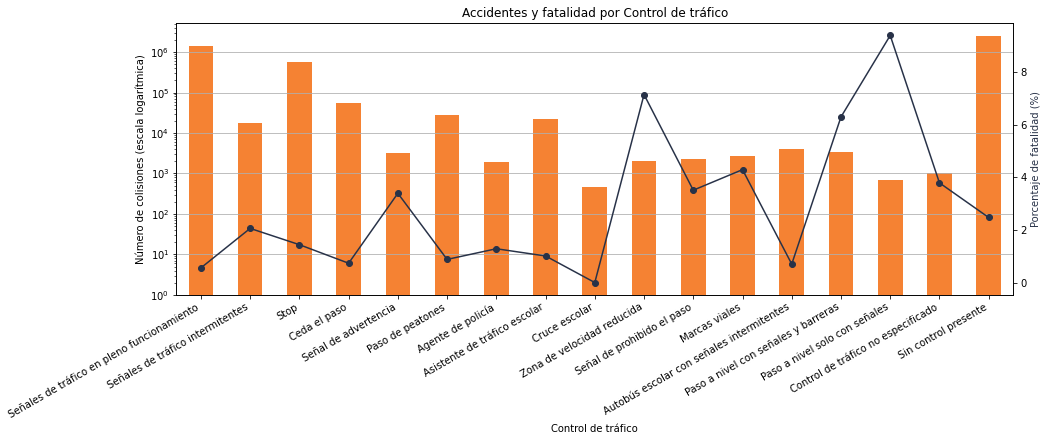

In [35]:
traf_type = ['Señales de tráfico en pleno funcionamiento','Señales de tráfico intermitentes',
             'Stop','Ceda el paso','Señal de advertencia','Paso de peatones',
             'Agente de policía','Asistente de tráfico escolar','Cruce escolar','Zona de velocidad reducida',
             'Señal de prohibido el paso','Marcas viales',
             'Autobús escolar con señales intermitentes','Paso a nivel con señales y barreras',
             'Paso a nivel solo con señales','Control de tráfico no especificado','Sin control presente']

barplot_fatality(df_2, 'c_traf', 'Control de tráfico', traf_type)

## 4. Configuración de la vía

### 4.1 Relación entre configuración de vía y el tiempo

La mayoría de los accidentes ocurren en carreteras a nivel, razón por la que se asume que los vehículos viajan con más velocidad y el conductor no presta la atención necesaria ya que el estado de la vía es bueno.

Comprobamos los valores que no conocemos:

In [36]:
df['c_raln'].value_counts().sort_index()

1    4299649
2     551358
3     340004
4     213348
5      35262
6      25628
Name: c_raln, dtype: int64

Agregamos los datos por mes:

In [21]:
df_month_raln_grouped = df.groupby(['date','c_raln']).size().unstack()
df_month_raln_grouped.head()

c_raln,1,2,3,4,5,6
date,,,,,,
1999-01-01,23364,3905,2212,1555,141,128
1999-02-01,18829,2799,1764,1185,106,93
1999-03-01,21241,3046,1821,1214,122,82
1999-04-01,20998,2895,1565,968,82,74
1999-05-01,26380,3586,1818,1174,126,65


**Correlación con el tiempo:**

Visualizamos el resultado:

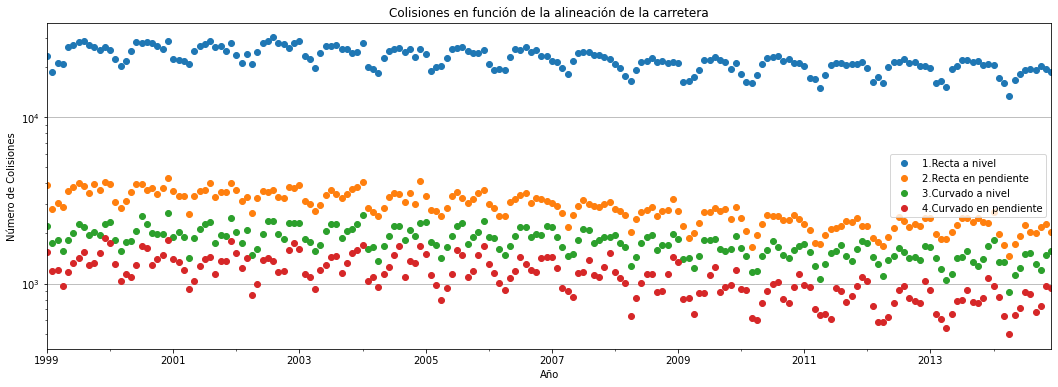

In [22]:
c_raln=['1.Recta a nivel','2.Recta en pendiente',
        '3.Curvado a nivel','4.Curvado en pendiente',
        '5.Parte alta de una pendiente','6.Parte baja de una pendiente',
        'Q.Otros']

df_month_raln_grouped.iloc[:,:-2].plot(logy=True, style = 'o', figsize = (18,6),
                     title = 'Colisiones en función de la alineación de la carretera')
plt.legend(c_raln)
plt.xlabel('Año')
plt.ylabel('Número de Colisiones')
plt.grid(axis='y');

Aplicamos un tercer eje para poder comparar el número de accidentes con la tasa de mortalidad de los mismos según la configuración de la vía:

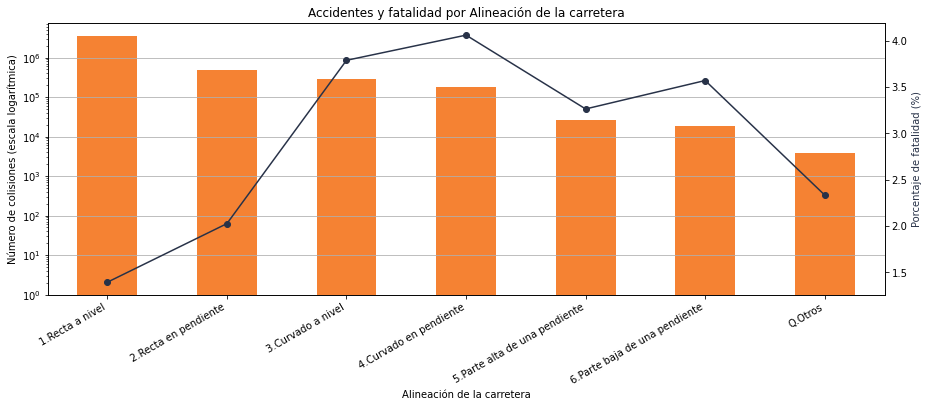

In [35]:
barplot_fatality(df_2, 'c_raln', 'Alineación de la carretera', c_raln)

### 4.2 Configuración de via y severidad del accidente

Los accidentes mortales representan únicamente menos del 4% de todos los casos. Es evidente que las carreteras a nivel tienen menos accidentes mortales. Las curvas y las vías con desnivel son más peligrosas. Esto podría darse por la baja visivilidad.

El número de accidentes según los vehículos involucrados disminuye considerablemente, siendo menos común los accidentes con muchos vehículos.

**Pasos:**
1. Calculamos la proporción de accidente para cada evento
2. Categorizamos el número de vehículos en bins
3. Resumen de vehículos involucrados y el tipo de vía

In [36]:
df_raln_vehs = df[['c_raln','c_vehs']]
df_raln_vehs.c_vehs.replace('UU',np.nan, inplace=True)
df_raln_vehs.dropna(inplace=True)
df_raln_vehs.c_vehs = df_raln_vehs.c_vehs.astype(int)

df_raln_vehs['acc']= 1/df_raln_vehs.c_vehs

bins = [0,5,10,20,40,60]
df_raln_vehs['cats'] = pd.cut(df_raln_vehs.c_vehs,bins)

df_raln_vehs_transf = df_raln_vehs.groupby(['cats','c_raln'])['acc'].sum().unstack()
df_raln_vehs_transf.dropna(how='all', inplace=True)
df_raln_vehs_transf.fillna(0, inplace=True)

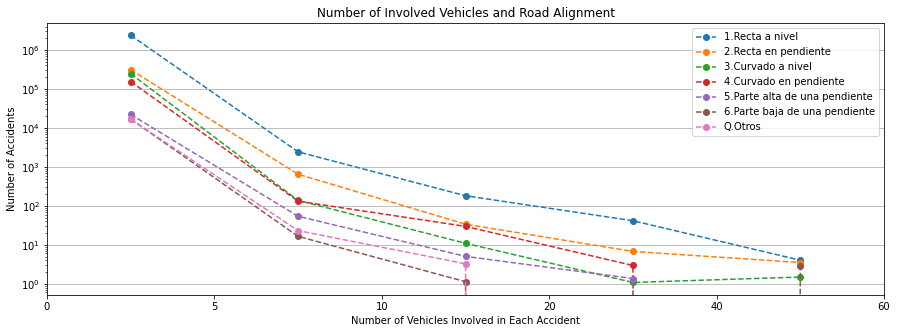

In [37]:
df_raln_vehs_transf.plot(logy=True,figsize=(15,5),style='o--',
         title='Number of Involved Vehicles and Road Alignment')
plt.xticks(np.arange(-0.5,5.5),bins)
plt.xlabel('Number of Vehicles Involved in Each Accident')
plt.ylabel('Number of Accidents')
plt.legend(c_raln)
plt.grid(axis='y');

### 4.4 Configuración de vía y tipo de accidente

El tamaño de cada círculo indica el numero de accidentes, comparable con los otros puntos en proporción. Se puede concluir que la tendencia aumenta cuando la configuración de la vía mejora, dada la valocidad y la falta de precaución:

1. La mayoría de accidentes de un solo coche son contra un objeto estático
2. Dos vehículos en la misma dirección, los accidentes son por la parte de atrás
3. Para vehículos en direcciones apuestas, el angulo derecho es el de mayor frecuencía, se asume que accidentes en intersecciones

**Conclusiones Configuración de la Vía:**
1. La mayoría de los accidentes ocurren en carreteras normales a nivel. Esto se debe por la velocidad y la falta de atención de los conductores.
2. El mal estado de las carreteras afecta positivamente a que haya un accidente mortal. Los conductores tiene que estar atentos en estas situaciones.
3. Accidentes provocados por collisiones en la parte trasera son los más populares.
4. Accidentes provocados por golpes en los angulos derechos e izquierdos también son populares.

Se nota una alta frecuencia de la variable 'Otros' en accidentes de 1 solo vehículo y 2 vehículos en sentido contratio. En los casos a parte, se agrupan los accidentes que contienen más de 2 vehículos y distintas direcciones de los mismos, los cuales son menos frecuentes.

In [23]:
df_conf_raln = df_2.groupby(['c_conf', 'c_raln']).sum().reset_index()
df_conf_raln['collision'] = df_conf_raln.fatal + df_conf_raln.non_fatal
df_conf_raln = df_conf_raln[['c_raln', 'c_conf', 'collision']]

In [39]:
def heatmap_collision (title, c_conf_values, c_conf_tags, facet_row, facet_col):
    '''
    Función que devuelve un heatmap entre c_conf y c_raln. Permite realizar un facet de gráficos.
    
    :param title: título del gráfico
    :param c_conf_values: valores codificados de c_conf por los que filtrar el dataframe a representar
    :param c_conf_tags: nombre de los valores de c_conf filtrados para mostrar en el eje Y
    :param facet_row: fila del gráfico a representar en la matriz de gráficos (FacetGrid de Seaborn)
    :param facet_col: columna del gráfico a representar en la matriz de gráficos (FacetGrid de Seaborn)
    :return: objeto de seaborn
    '''
    
    df_c_conf_c_raln = df_conf_raln[df_conf_raln.c_conf.isin(c_conf_values)]
    df_c_conf_c_raln = df_c_conf_c_raln.pivot('c_conf', 'c_raln', 'collision')
    
    ax = sns.heatmap(df_c_conf_c_raln, annot=True, vmin=500, vmax=120000, cmap="YlGnBu", ax=axes[facet_row,facet_col])
    ax.set_title(title)
    ax.set_yticks(np.arange(0.5,len(c_conf_tags)+.5))
    ax.set_yticklabels(c_conf_tags,rotation=30,ha='right')
    
    if facet_col == 0:
        ax.set_ylabel('Configuración de Colisión')
    else:
        ax.set_ylabel('')
    if facet_row == 1:
        ax.set_xlabel('Alineación de Carretera')
        ax.set_xticks(np.arange(0.5,7.5))
        ax.set_xticklabels(c_raln, rotation=30, ha='right')
    else:
        ax.set_xlabel('')

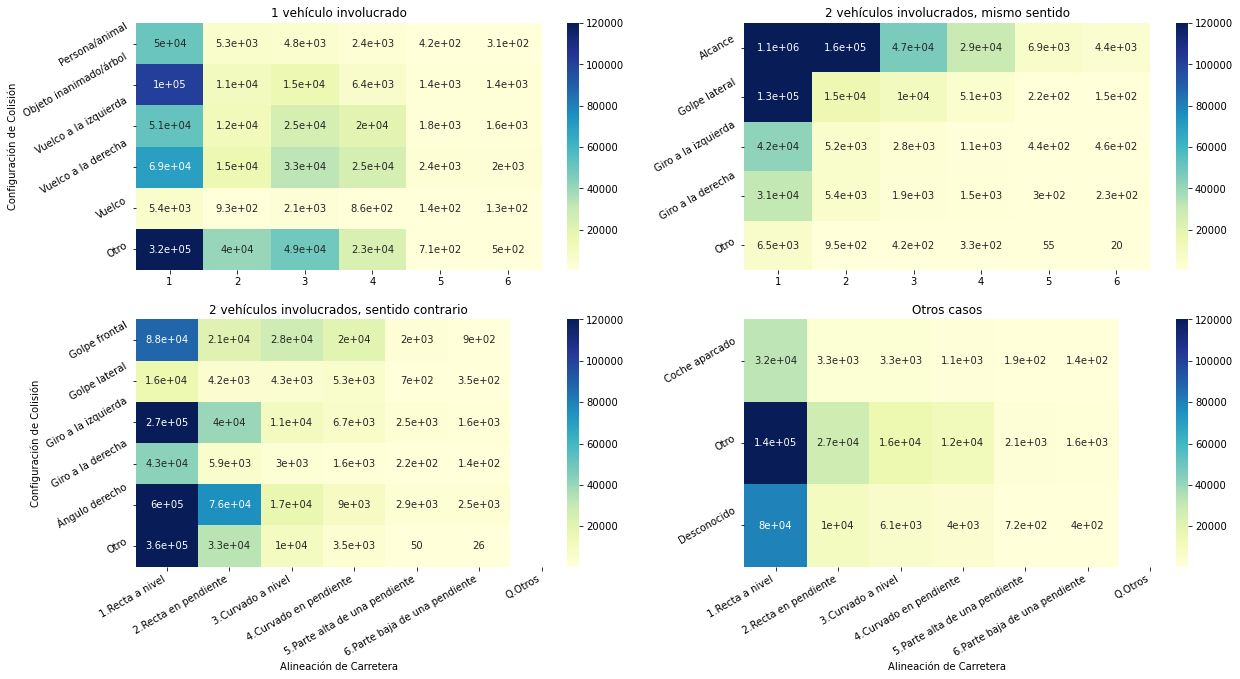

In [24]:
# Representación 
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

#1 vehículo en el accidente
c_conf_single_vehicle = ['01','02','03','04','05','06']
c_conf_single_vehicle_tags = ['Persona/animal','Objeto inanimado/árbol','Vuelco a la izquierda',
                              'Vuelco a la derecha','Vuelco','Otro']
heatmap_collision(df_conf_raln, '1 vehículo involucrado', c_conf_single_vehicle, c_conf_single_vehicle_tags, 0, 0, axes)

# 2 vehículos en la misma dirección
c_conf_two_same = ['21','22','23','24','25']
c_conf_two_same_tags = ['Alcance','Golpe lateral','Giro a la izquierda','Giro a la derecha','Otro']
heatmap_collision(df_conf_raln, '2 vehículos involucrados, mismo sentido', c_conf_two_same, c_conf_two_same_tags, 0, 1, axes)

# 2 vehículos en diecciones opuestas
c_conf_two_opposite = ['31','32','33','34','35','36']
c_conf_two_opposite_tags = ['Golpe frontal','Golpe lateral','Giro a la izquierda','Giro a la derecha','Ángulo derecho', 'Otro']
heatmap_collision(df_conf_raln, '2 vehículos involucrados, sentido contrario', c_conf_two_opposite, c_conf_two_opposite_tags, 1, 0, axes)

# Otras situaciones
c_conf_other = ['41','QQ','UU','XX']
c_conf_other_tags = ['Coche aparcado','Otro','Desconocido']
heatmap_collision(df_conf_raln, 'Otros casos', c_conf_other, c_conf_other_tags, 1, 1, axes)

## 5. Análisis tipo de vehículo
### 5.1 Tipo de vehículo y porcentage de mortalidad

Se observa que el mayor numero de accidentes los tienen los vehículos ligeros. Se puede asumir que cuanto mayor sea el número de vehículos de el mismo tipo circulando, más alto es la probabilidad de que ese mismo se vea involucrado en un accidente.

El porcentage más alto de mortalidad son los tractores. El bajo número de accidentes contrastado con los accidentes que han sufrido mortalidad, es en proporciones más alto que el de vehículo ligero.

Hay más probabilidades de sufrir un accidente en un ligero, pero menos de sufrir un accidente mortal.

**Conclusiones por el typo de vehículo:**
1. Los autobuses escolares sufren más accidentes durante verano (Julio y Agosto).
2. Vehículos para actividades exteriores sufren más accidentes en venrano (Julio a Octubre).
3. Los vehículos con la tasa de mortalidad más alta son los tractores, streetcar y motorhome.

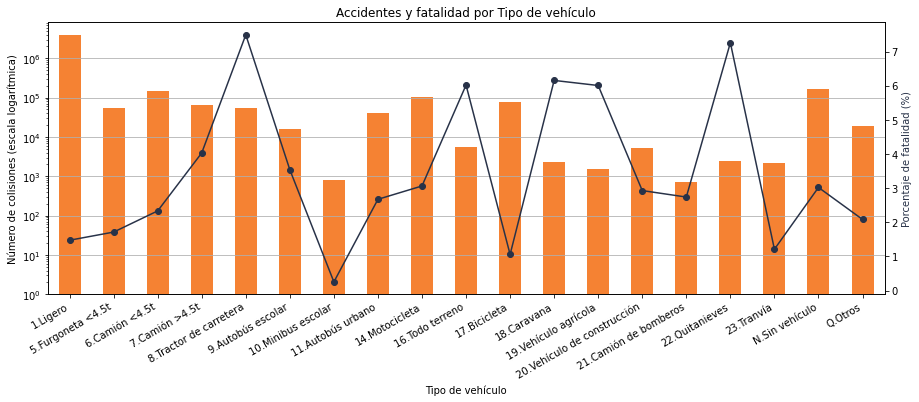

In [41]:
v_type = ['1.Ligero', '5.Furgoneta <4.5t', '6.Camión <4.5t',
          '7.Camión >4.5t', '8.Tractor de carretera', '9.Autobús escolar',
          '10.Minibus escolar', '11.Autobús urbano', '14.Motocicleta',
          '16.Todo terreno', '17.Bicicleta', '18.Caravana', '19.Vehículo agrícola',
          '20.Vehículo de construcción', '21.Camión de bomberos', '22.Quitanieves',
          '23.Tranvía', 'N.Sin vehículo', 'Q.Otros']

barplot_fatality(df_2, 'v_type', 'Tipo de vehículo', v_type)

Se observa en el gráfico que las tasa de mortalidad es mayor en los tipos de vehículos que sufren menos accidentes, esto se debe a que a pesar de lo bajos que son los accidentes, los pocos que sean mortales incrementan la porporción respecto a otros vehículos.

Es más seguro viajar en un tractor por la autopista, pero el riesgo de sufrir un accidente mortal es superior a viajar en un ligero, que por tipo de vehículo es más peligroso.

In [42]:
df_2['v_type'].value_counts()

01    3814143
NN     170370
06     144308
14     101803
17      78007
07      63424
08      55602
05      54444
11      40017
QQ      19478
09      15879
16       5399
20       5121
22       2466
18       2372
23       2146
19       1515
10        786
21        730
Name: v_type, dtype: int64

## 6. Año del vehículo
### 6.1 Año modelo vehículo

Se puede observar que los vehículos mas antiguos (1990 a 2000) tieneden a decrecer en el número de accidentes. Los vehículos más nuevos, por una relación de sustitución en el mercado y aumento de la seguridad, aumentan en el número de accidentes.

**Pasos:**
1. Seleccionamos los datos que vamos a utilizar
2. Sustituimos los valores NA
3. Añadimos el año del modelo de vehículo como índice y agrupamos

In [43]:
df_c_v_year = df[['c_year','v_year']]

df_c_v_year.v_year.replace({'NNNN':np.nan,'UUUU':np.nan,'XXXX':np.nan},inplace=True)
df_c_v_year.dropna(inplace=True)
df_c_v_year = df_c_v_year.astype(int)

df_c_v_year_group = df_c_v_year.groupby(['v_year','c_year']).size().unstack()
df_c_v_year_group.fillna(0, inplace=True)
df_c_v_year_group = df_c_v_year_group.astype(int)

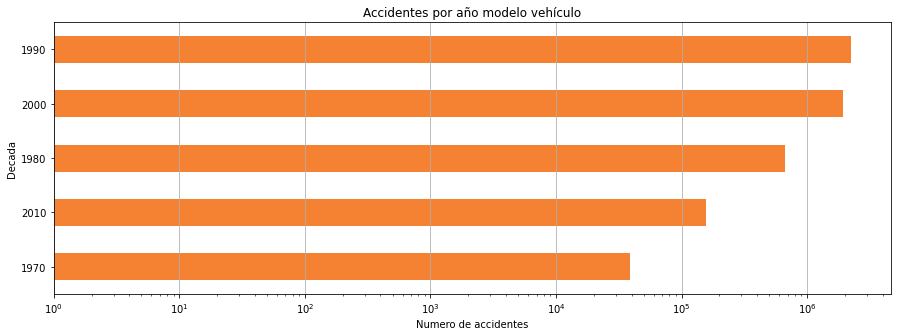

In [44]:
bins = list(range(1900,2021,10))
df_c_v_year_group['categ'] = pd.cut(df_c_v_year_group.index,bins,labels=bins[:-1])
df_c_v_year_group_categ = df_c_v_year_group.groupby('categ').sum().T

se_c_v_year_group = df_c_v_year_group_categ.sum().sort_values()
se_c_v_year_group[-5:].plot.barh(log=True,color='#F58233',figsize=(15,5),
                                 title='Accidentes por año modelo vehículo')
plt.xlabel('Numero de accidentes')
plt.ylabel('Decada')
plt.grid(axis='x');

Evolución a lo largo del tiempo:

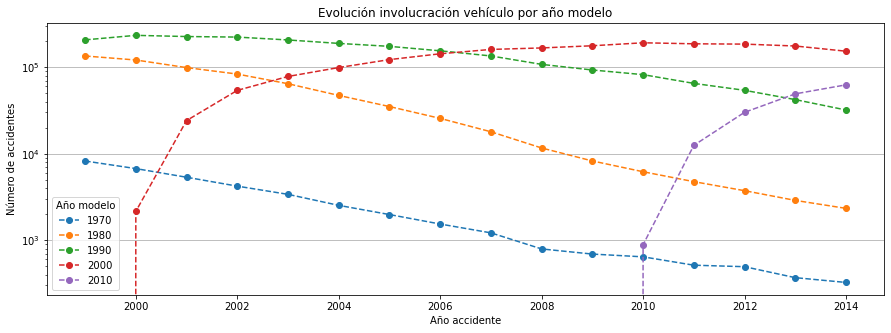

In [45]:
df_c_v_year_group_categ.iloc[:,7:].plot(logy=True,style='o--',figsize=(15,5),
                    title='Evolución involucración vehículo por año modelo')
plt.xlabel('Año accidente')
plt.ylabel('Número de accidentes')
plt.legend(title='Año modelo')
plt.grid(axis='y');

**Pasos:**
1. Creamos un nuevo dataframe en el cual crearemos una nueva columna con la antiguedad del coche. Para ello, eliminaremos aquellos registros que sean peatones, o lo que es lo mismo, aquellos cuya antiguedad de vehículo es 'NNNN', y aquellos cuya antiguedad sea desconocida ('UUUU')

2. Agrupamos la antiguedad de los vehículos de 5 en 5. La antiguedad del vehículo es orientativa, ya que no es lo mismo año del modelo que año de fabricación/adquisición, razón por la que existen valores negativos

3. Deshacemos la eliminación de valores 'NNNN' y 'UUUU' para que sean representados

Visualizamos el resultado:

In [46]:
df_2_old = df_2.copy()
df_2_old = df_2_old[~df_2_old.v_year.isin(['NNNN','UUUU'])]
df_2_old.v_year = pd.to_numeric(df_2_old.v_year)
df_2_old['v_old'] = df_2_old.c_year - df_2_old.v_year

df_2_old['bin'] = pd.cut(df_2_old['v_old'], bins=range(-5,105,5), labels=[f'{l}-{l+10}' for l in range(-5,100,5)])

df_2_old_aux = df_2[df_2.v_year.isin(['NNNN','UUUU'])]
df_2_old_aux['bin'] = df_2_old_aux.v_year
df_2_old_aux['v_old'] = df_2_old_aux.v_year
df_2_old.v_year = df_2_old.v_year.astype(object)
df_2_old = df_2_old.append(df_2_old_aux)

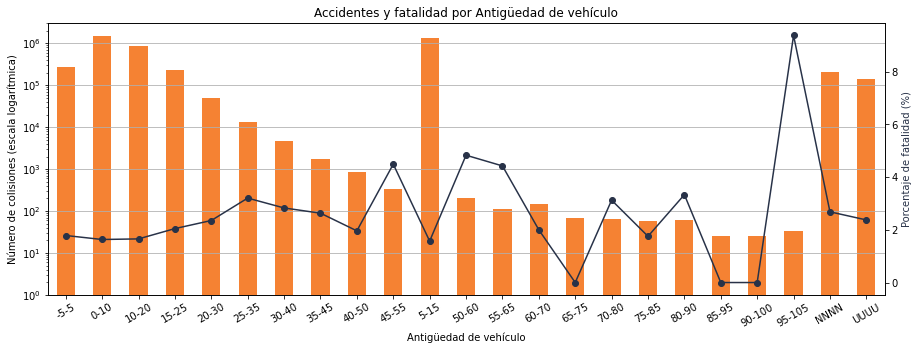

In [47]:
barplot_fatality(df_2_old, 'bin', 'Antigüedad de vehículo')

## 7. Sexo personas
### 7.1 Hora de collision y sexo persona

El hombre tiene mas tendencia a sufrir un accidente en todo momento del día. Podemos observar que los tiempos de collision entre hombre y mujer coinciden a las 8pm.

Los tiempos de más riesgo de accidente son entre als 3pm y las 5pm.

In [48]:
df_sex = df_2.loc[:,['c_hour','c_vehs','c_wday',
                 'c_conf','p_sex','p_age','p_isev','p_user']]

Convertimos la variable categórica a numérica y eliminamos los valores missing:

In [49]:
df_sex.p_sex.replace({'M':0,'F':1},inplace=True)

df_sex.replace('[^0-9]+',np.nan,regex=True,inplace=True)
df_sex.dropna(inplace=True)

Dividimos los datos para visualizar la relación entre sexo y hora de accidente:

In [50]:
df_sex_vis = df_sex.loc[:,['p_sex','c_hour']].groupby(['c_hour','p_sex']).size().unstack()

VIsualización filtrada:

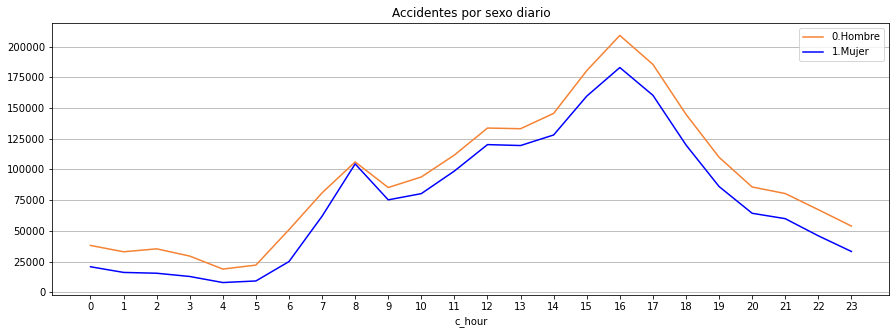

In [51]:
df_sex_vis.plot(rot=0,color=['#F58233','b'],figsize=(15,5),
         title='Accidentes por sexo diario')
plt.legend(['0.Hombre','1.Mujer'])
plt.xticks(range(0,24),range(0,24))
plt.grid(axis='y');

Dividimos los datos para visualizar la relación entre sexo y día de accidente:

In [52]:
df_sex_wday = df_sex.loc[:,['p_sex','c_wday']].groupby(['c_wday','p_sex']).size().unstack()

Visualización datos filtrados sexo y día de accidente:

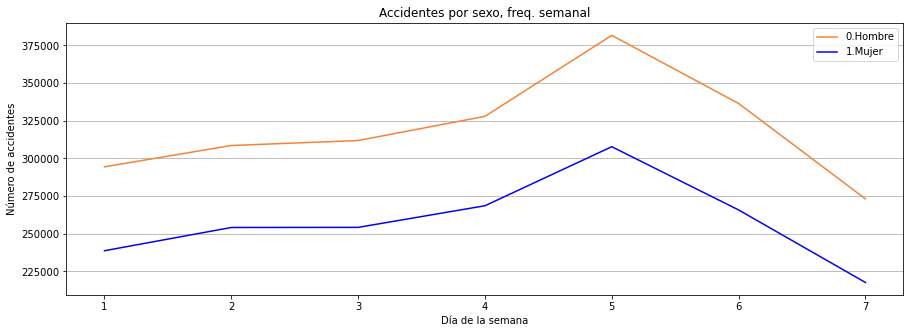

In [53]:
df_sex_wday.plot(rot=0,color=['#F58233','b'],figsize=(15,5),
         title='Accidentes por sexo, freq. semanal')
plt.xlabel('Día de la semana')
plt.ylabel('Número de accidentes')
plt.legend(['0.Hombre','1.Mujer'])
plt.grid(axis='y');

### 7.2 Sexo de persona y tratamiento médico

Las mujeres tiene más tendencia a sufir daños en una ccidente, comparado con el hombre.
Mueren más hombres en accidentes en comparación con las mujeres.

In [26]:
df_med = df_2.loc[:,['p_sex','p_isev']].groupby(['p_sex','p_isev']).size().unstack()

Eliminamos las columnas N y U:

In [27]:
df_med = df_med.drop(columns=['N', 'U'])
df_med = df_med.drop(labels=['N', 'U'], axis=0)

Pasamos los valores a escala logatírmica y visualizamos:

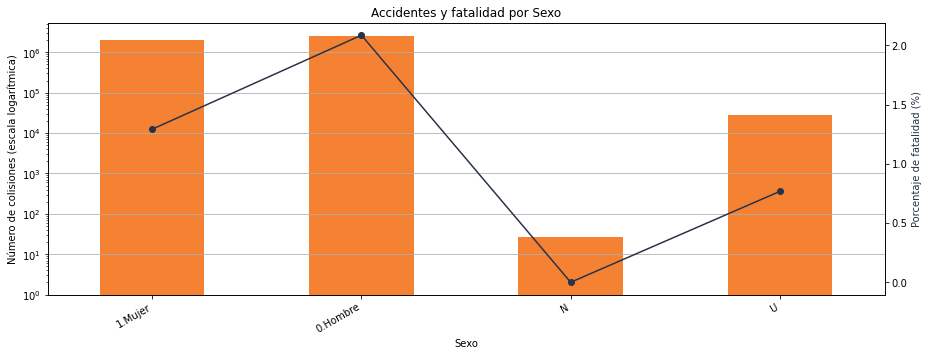

In [30]:
p_sex_types = ['1.Mujer','0.Hombre', 'N', 'U']
barplot_fatality(df_2, 'p_sex', 'Sexo', p_sex_types)

### 7.3 Sexo de persona y tipo de accidente (configuración)

Para todas las configuraciones de accidente, el hombre tiene mas riesgo que la mujer. Los accidentes por la parte trasera son el tipo más frecuente de accidente para ambos sexos. El segundo tipo de accidente más común es por la parte derecha. \
En Canadá se sigue la misma dirección de conducción que Estados Unidos, el ángulo trasero derecho tiene peor visión que el izquierdo.

- SV = 1 vehículo
- 2V = 2 vehículos o más

In [57]:
df_sex_conf = df_2.loc[:,['p_sex','c_conf']].groupby(['c_conf','p_sex']).size().unstack()

In [58]:
df_sex_conf = df_sex_conf.drop(columns=['N', 'U'])
df_sex_conf = df_sex_conf.drop(labels=['QQ', 'UU'], axis=0)

In [59]:
x_label=['01.SV Golpe móvil','02.SV Golpe estacionario','03.SV Descarrilamiento izquierdo',
         '04.SV Descarrilamiento derecho','05.SV Vuelta de campana en autopista',
         '06.SV Otros','21.2V SD Trasero','22.2V SD golpe lateral',
         '23.2V SD Lf','24.2V SD Rt','25.2V Otros','31.2V DD Delantero',
         '32.2V DD golpe lateral','33.2V DD Lf','34.2V DD Rt','35.2V DD Angulo derecho',
         '36.2V DD Otros','41.Hit vehículo aparcado'] 

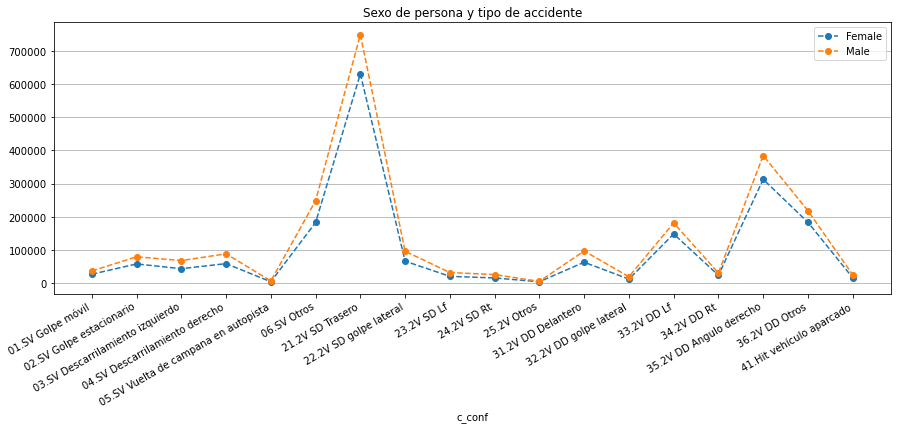

In [60]:
df_sex_conf.plot(style = 'o--', figsize = (15,5),
         title='Sexo de persona y tipo de accidente')
plt.legend(['Female','Male'])
plt.xticks(range(0,18),x_label,rotation=30,ha='right');
plt.grid(axis='y');

## 8. Edad de la persona
### 8.1 Edad de la persona y hora de accidente

La población con más accidentes se encuentran en el intervalo de edad entre los 21 y 30 años. Los jovenes de este intervalo de edad son los que más se ven involucrados en accidentes durante la noche.

Durante las mañanas, entre las 8am y las 11am es un intervalo de tiempo en el que los grupos de edad de 20 a 30, 30 a 40 y 40 a 50 años sufren más accidentes. Se asume el resultado y se acepta ya que son las edades laborales con desplazamiento más frecuentes. Si se hiciera una comparativa con valores de COVID, se podría ver un descenso importante en el número de accidentes durantes las mañanas entre semana.

In [61]:
# Transformamos los datos numéricos y eliminamos los NA
df_age_h = df_2.loc[:,['p_age','c_hour']].astype(int).groupby(['p_age','c_hour']).size().unstack()
df_age_h.fillna(0, inplace=True)

In [62]:
# Creamos grupos de décadas para agrupar las edades
bins = list(range(0,101,10))
df_age_h['age'] = pd.cut(df_age_h.index,bins,labels=bins[:-1])
df_age_h = df_age_h.groupby('age').sum()
df_age_h = df_age_h.T

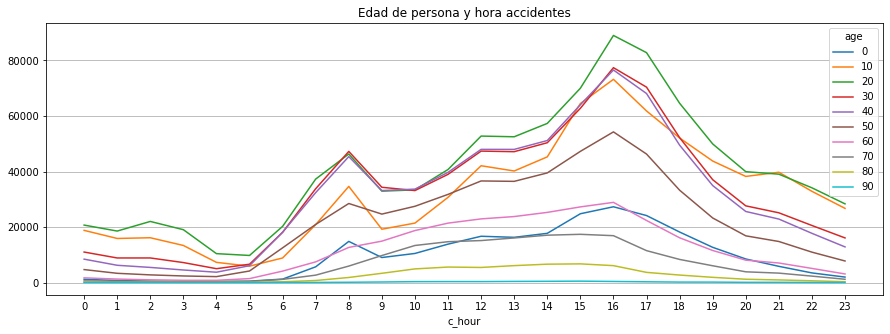

In [63]:
# Visualizamos la distribución de accidentes por edades
df_age_h.plot(rot=0,figsize=(15,5), title='Edad de persona y hora accidentes')
plt.xticks(range(0,24),range(0,24))
plt.xticks(range(0,24),range(0,24))
plt.grid(axis='y');

### 8.2 Edad persona y día de la semana

Durante toda la semana los adultos entre 20 y 30 años son los que tienen mas riesgo. El riesgo disminuye con el crecimiento de la edad de la población. La probabilidad de accidente aumenta el fin de semana con la población más jóven.

In [64]:
df_age_wday = df_2.loc[:,['p_age','c_wday']].astype(int).groupby(['c_wday','p_age']).size().unstack().T

In [65]:
bins = list(range(0,101,10))
df_age_wday['age'] = pd.cut(df_age_wday.index,bins,labels=bins[:-1])
df_age_wday = df_age_wday.groupby('age').sum()
df_age_wday = df_age_wday.T

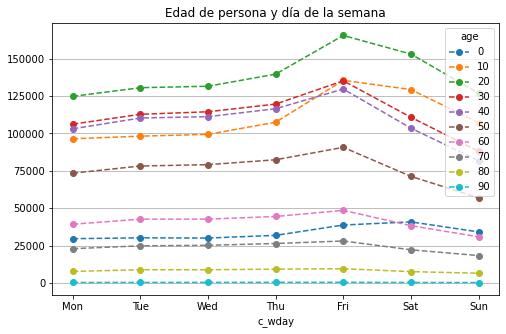

In [66]:
df_age_wday.plot(rot=0,figsize=(8,5),title='Edad de persona y día de la semana',style='o--')
plt.xticks(range(1,8),['Mon','Tue','Wed','Thu','Fri','Sat','Sun']);
plt.grid(axis='y');

### 8.3 Edad de la persona y tratamiento médico

El tratamiento médico aumenta con la edad, ya que las personas de mayor edad tiene más probabilidad por estado físico de sufrir daños en un accidente. Sufren menos número de accidentes pero con mayor probabilidad en proporción al total en el que se necesita tratamiento médico.

Igual que anteriormente, los jóvenes son los más propensos a tener un accidente pero requieren menos tratamiento médico que las personas de mayor edad.

In [31]:
# Filtramos para utilizar únicamente datos numéricos
df_2 = df_2[df_2['p_isev'].str.contains('[0-9]')]

In [32]:
# Seleccionamos los datos y eliminamos los nulos
df_age_med = df_2.loc[:,['p_age','p_isev']].astype(int).groupby(['p_age','p_isev']).size().unstack()
df_age_med.fillna(0, inplace=True)

In [33]:
# Agrupamos los datos por edad en intervalos de 10 años
bins = list(range(0,101,10))
df_age_med['age'] = pd.cut(df_age_med.index,bins,labels=bins[:-1])
df_age_med = df_age_med.groupby('age').sum()

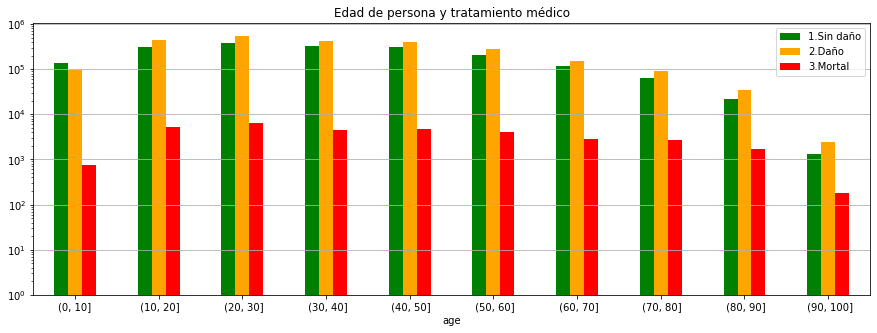

In [37]:
# Viualizamos aplicando logs
df_age_med.plot(kind='bar',rot=0, color=['g','orange','r'],log=True, figsize=(15,5),
         title='Edad de persona y tratamiento médico')
plt.legend(['1.Sin daño','2.Daño','3.Mortal'])
plt.xticks(range(0,10),['(0, 10]',' (10, 20]',' (20, 30]',' (30, 40]',
                        ' (40, 50]',' (50, 60]',' (60, 70]',' (70, 80]',
                        ' (80, 90]',' (90, 100]'])
plt.grid(axis='y');

## 9. Usuario en carretera
### 9.1 Usuario y tratamiento médico

Los conductores tiene más probabilidad de morir o hacerse daño en un accidente en comparación con los pasajeros. Entre todas las categorias el ciclista es la mas segura.

In [71]:
# Filtramos para utilizar únicamente datos numéricos
df_2 = df_2[df_2['p_user'].str.contains('[0-9]')]

In [72]:
# Transformamos los datos y eliminamos nulos
df_pro_med = df_2.loc[:,['p_user','p_isev']].astype(int).groupby(['p_user','p_isev']).size().unstack()
df_pro_med.fillna(0, inplace=True)

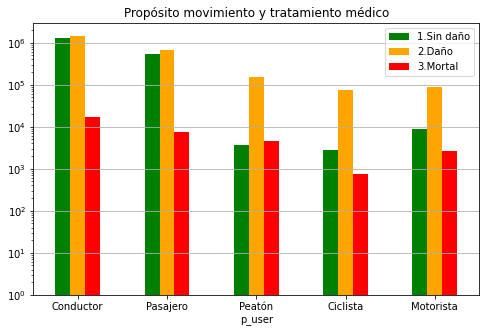

In [73]:
# Visualización de los datos logs
df_pro_med.plot(kind='bar',rot=0,log=True, color=['g','orange','r'],figsize=(8,5),
          title='Propósito movimiento y tratamiento médico')
plt.legend(['1.Sin daño','2.Daño','3.Mortal'])
plt.xticks(range(0,5),['Conductor','Pasajero','Peatón',
                       'Ciclista', 'Motorista'])
plt.grid(axis='y');

### 9.2 Tipo de usuario y configuración collisión

El tipo más común de accidente es por detrás y por el ángulo derecho trasero, tanto para conductores como pasajeros.

Es poco común que un vehículo de vueltas de campana y se lleve a un cilcista por delante.

In [74]:
# Filtramos para utilizar únicamente datos numéricos
df_2 = df_2[df_2['c_conf'].str.contains('[0-9]')]

In [75]:
df_pro_conf = df_2.loc[:,['p_user','c_conf']].groupby(['c_conf','p_user']).size().unstack()
df_pro_conf.fillna(0,inplace=True)

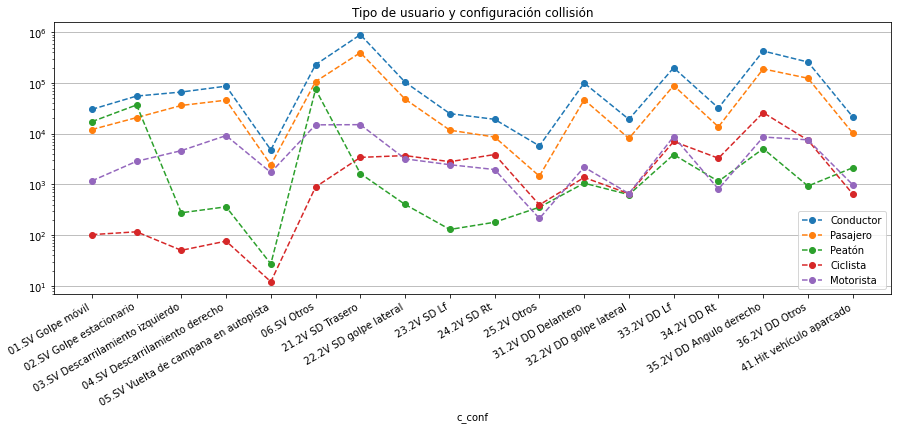

In [76]:
df_pro_conf.plot(style = 'o--', logy = True, figsize = (15,5),
          title='Tipo de usuario y configuración collisión' )
plt.legend(['Conductor','Pasajero','Peatón',
            'Ciclista', 'Motorista'])
plt.xticks(range(0,18),x_label,rotation=30,ha='right')
plt.grid(axis='y');

## 10. Vehículos involucrados en accidentes
### 10.1 Relación entre vehículos involucrados en accidentes y tiempo

El número más frecuente de vehículos involucrados son 2 vehículos.

In [77]:
# Seleccionamos los datos
df_c = df_2.loc[:,['c_year','c_mnth','c_wday',
                  'c_hour','c_sev','c_vehs','c_conf','p_psn','p_safe']]
df_c[['c_sev','c_vehs','c_conf','p_psn','p_safe']] =\
        df_c[['c_sev','c_vehs','c_conf','p_psn','p_safe']].replace('^([A-Za-z])+$', np.nan, regex=True)
df_c = df_c.dropna()

# Eliminamos el 0 que procede al número
df_c[['c_vehs','c_conf','p_safe']] = df_c[['c_vehs','c_conf','p_safe']].fillna(-1).astype(int)

In [78]:
# Filtramos los datos que vamos a utilizar
df_veh = df_c.loc[:,['c_vehs']]

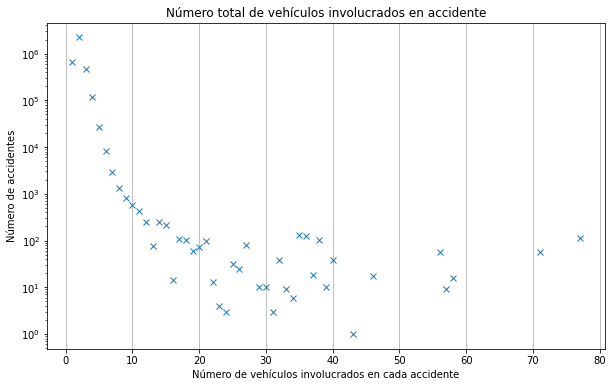

In [79]:
# Agrupamos y ordenamos los datos
df_veh_2 = df_veh.groupby('c_vehs').size().sort_index()

# Visualización
df_veh_2.plot(style='x',logy=True, figsize=(10,6),
         title='Número total de vehículos involucrados en accidente')

# Aplicamos información al gráfico
plt.grid(axis='x');
plt.xlabel('Número de vehículos involucrados en cada accidente')
plt.ylabel('Número de accidentes');

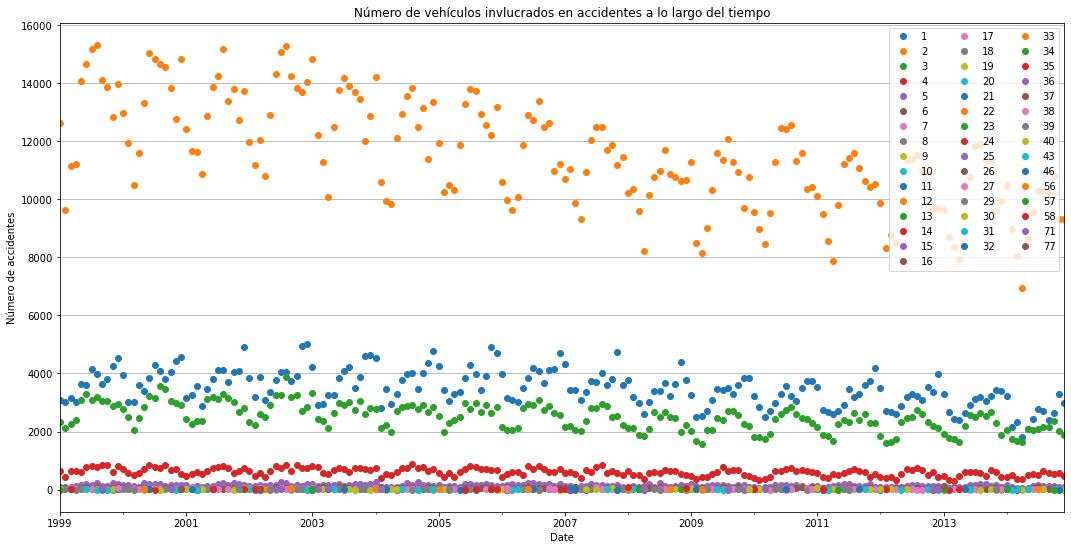

In [80]:
# Agrupamos datos por numero de vehículos
vehs = df_veh.groupby(['date','c_vehs']).size().unstack()

vehs.plot(style = 'o', figsize=(18,9),
                  title = 'Número de vehículos invlucrados en accidentes a lo largo del tiempo')
plt.grid(axis='y')
plt.xlabel('Date')
plt.legend(ncol=3)
plt.ylabel('Número de accidentes');

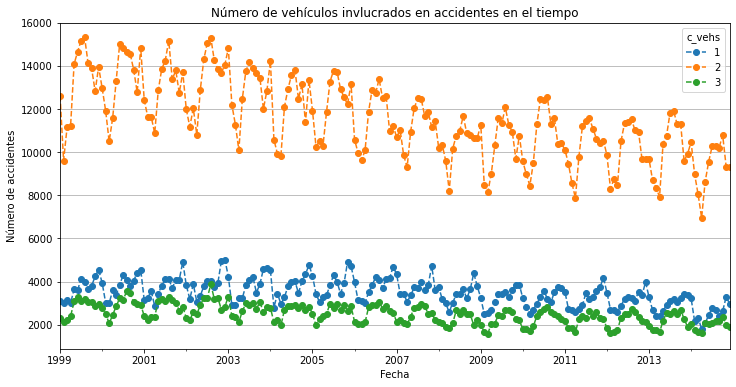

In [81]:
# Seleccionamos los 3 más frecuentes
vehs_5 = vehs.iloc[:,0:3]
vehs_5.plot(style='o--',figsize=(12,6),
       title='Número de vehículos invlucrados en accidentes en el tiempo')
plt.xlabel('Fecha')
plt.ylabel('Número de accidentes')
plt.grid(axis='y');

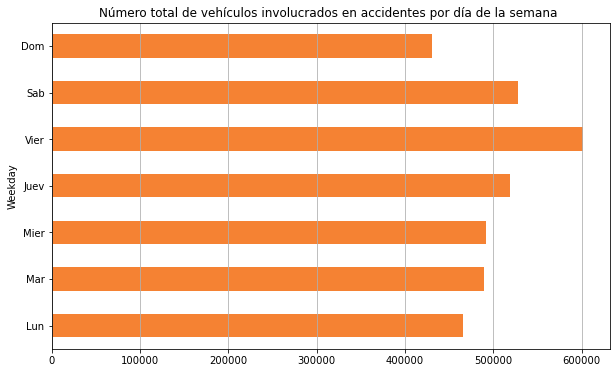

In [82]:
# Seleccionamos los datos por semanas y numero de accidentes
df3 = df_c.loc[:,['c_wday','c_vehs']]
weekday = ['Lun', 'Mar', 'Mier', 'Juev', 'Vier', 'Sab', 'Dom']
w_day = df3.groupby('c_wday')['c_vehs'].size()

# Visualizamos
w_day.plot(kind='barh', color='#F58233',figsize=(10,6),rot =0,
           title='Número total de vehículos involucrados en accidentes por día de la semana ')
plt.yticks(range(0,7),weekday)
plt.ylabel('Weekday')
plt.grid(axis='x');

El siguiente gráfico nos muestra que el número de vehículos más frecuente en accidentes es 2 seguido de 1 y 3.

El día de la semana en el que se concentran más número de accidentes son los jueves y viernes, la tendencia decrease el domingo y resto de la semana.

**Día de la semana**

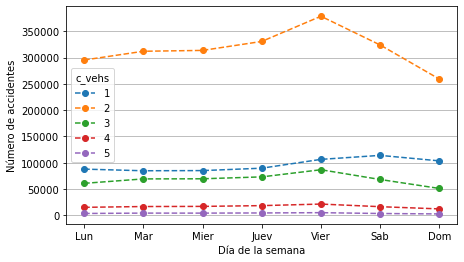

In [83]:
# Agrupamos los datos por día de la semana
w_day_num_vehs = df3.groupby(['c_wday','c_vehs']).size().unstack()

# Filtramos los top 5
top_5_num_vehs = w_day_num_vehs.iloc[:,0:5]

# Visualizamos los datos
top_5_num_vehs.plot(figsize=(7,4),style='o--')
plt.xlabel('Día de la semana')
plt.ylabel('Número de accidentes')
plt.xticks(range(1,8),weekday)
plt.grid(axis='y');

**Hora del Día**

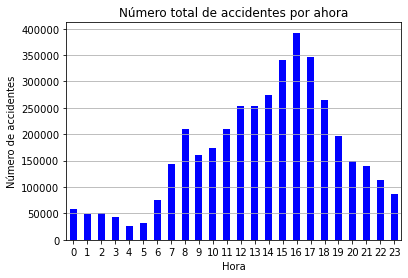

In [84]:
# Seleccionamos los datos por horas
df_hora = df_2.loc[:,['c_hour','c_vehs']]

# Agrupamos
hour = df_hora.groupby('c_hour')['c_vehs'].size()

# Visualizamos
hour.plot(kind='bar',color='blue',rot=0,
          title='Número total de accidentes por ahora')
plt.xlabel('Hora')
plt.ylabel('Número de accidentes')
plt.grid(axis='y');

### 10.3 Número de vehículos invlucrados en accidentes y severidad del accidente

In [85]:
# Seleccionamos los datos que vamos a utilizar
df_sev_acc = df_c.loc[:,['c_vehs','c_sev']]

# Agrupamos y cambiamos el indice del nuevo dataframe por la variable que nos ocupa
vehs_sev = df_sev_acc.groupby(['c_vehs','c_sev']).size().unstack()
vehs_sev.index = vehs_sev.index.astype(str)

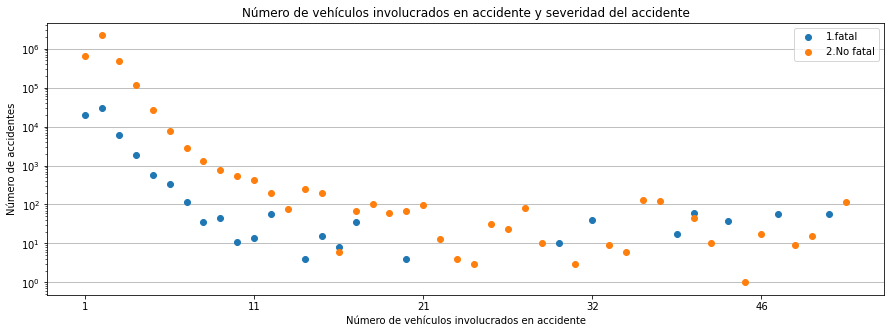

In [86]:
# Visualizamos el dataframe con el nuevo índice
vehs_sev.plot(logy=True,style = 'o', figsize=(15,5),
              title = 'Número de vehículos involucrados en accidente y severidad del accidente')
plt.grid(axis='y')
plt.legend(['1.fatal','2.No fatal'])
plt.xlabel('Número de vehículos involucrados en accidente') 
plt.ylabel('Número de accidentes');

## 11. Configuración del accidente
### 11.1 Configuración y tiempo

In [87]:
# Seleccionamos los datos que utilizamos, el índice es fecha automático
df_cong = df_c.loc[:,['c_conf']]

# Agrupamos los datos
configuration = df_cong.groupby(['date','c_conf']).size().unstack()

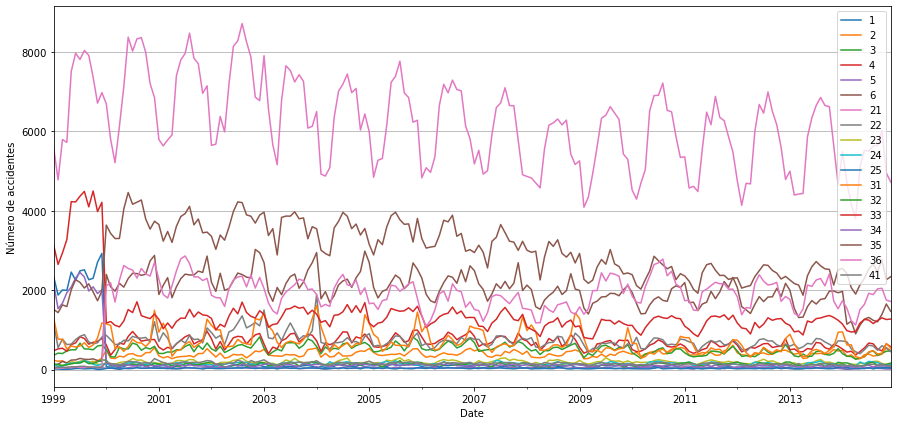

In [88]:
# Visualizamos los datos
configuration.plot(style='',figsize=(15,7))
plt.legend(loc=1)
plt.xlabel('Date')
plt.ylabel('Número de accidentes')
plt.grid(axis='y');

### 11.2 Configuración y severidad del accidente

In [89]:
# Seleccionamos los datos que vamos a utilizar
df_sev_conf = df_c.loc[:,['c_conf','c_sev']]

# Agrupamos por variable
conf_sev = df_sev_conf.groupby(['c_conf','c_sev']).size().unstack()
conf_sev.index = conf_sev.index.astype(str)

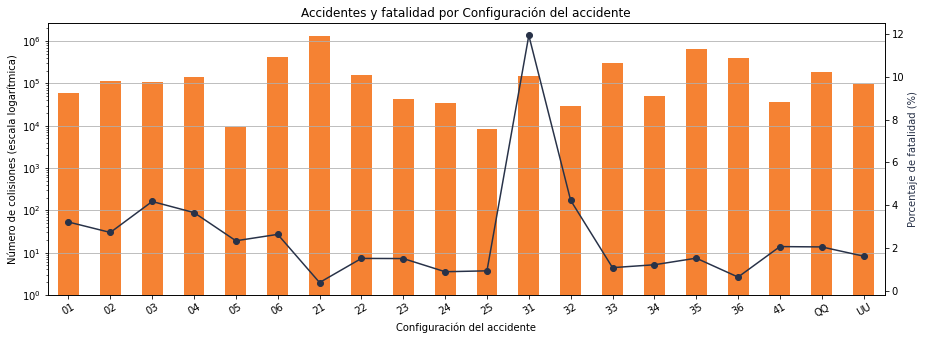

In [38]:
barplot_fatality(df_2, 'c_conf', 'Configuración del accidente')

## 12. Posición de la persona en el vehículo
### 12.1 Posición y severidad

Se observa que el mayor porcentage de mortalidad ocurre cuando la persona fallecida iba situada encima de otra. Por lo tanto se asume que sin ningún tipo de medida de seguridad. La segunda ocpuación es 'sin info', pero se puede asumir que algunos de esos accidentes coinciden con la persona fallecida viajando en el maletero.

Los ocupantes más comunes para tener accidentes son los conductores y los peatones. No solo es peligroso viajar en coche por el riesgo de sufrir accidentes, si no que el mero hecho de ir por la calle andando supone un riesgo de sufrir un accidente.

Como hemos visto anteriormente, el número de fallecidos es alto en las zonas de vaja velocidad, cuando ambos peatones y conductores bajan la guardia y sufren mas accidentes mortales.

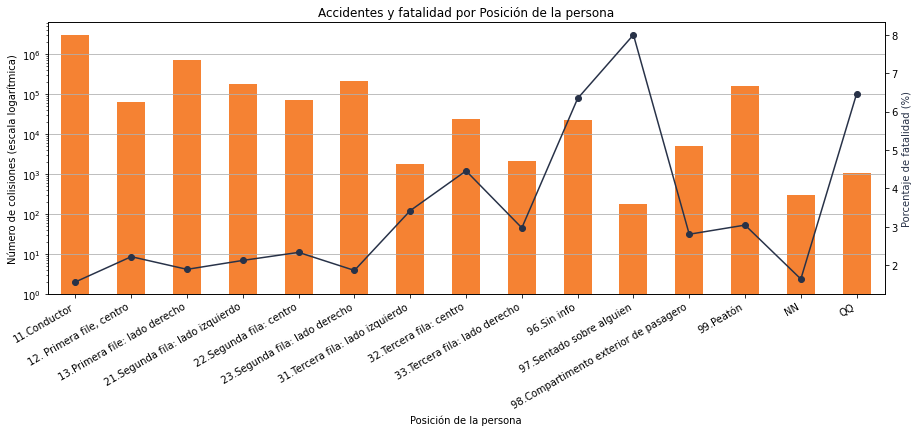

In [43]:
position = ['11.Conductor','12. Primera file, centro','13.Primera file: lado derecho',
            '21.Segunda fila: lado izquierdo','22.Segunda fila: centro',
            '23.Segunda fila: lado derecho','31.Tercera fila: lado izquierdo',
            '32.Tercera fila: centro','33.Tercera fila: lado derecho',
            '96.Sin info','97.Sentado sobre alguien',
            '98.Compartimento exterior de pasagero','99.Peatón', 'NN', 'QQ']
barplot_fatality(df_2, 'p_psn', 'Posición de la persona', position)

### 12.2 Posición persona y configuración

Se confirma con la información a anterior, los conductores sufren más accidentes debido a vehículos de baja ocupación más frecuentes en as vías. Y los peatones sufren más accidentes cuando solo un vehículo se ve involucrado en el accidente.

In [93]:
# Seleccionamos y agrupamos los datos por variables
df_pos_conf = df_c.loc[:,['p_psn','c_conf']]
psn_conf = df_pos_conf.groupby(['c_conf','p_psn']).size().unstack().fillna(0)
psn_conf.index = psn_conf.index.astype(str)

In [94]:
# Definimos los nombres de la variable configuración del accidente
conf = ['1. Accidente con objeto en movimiento',
        '2. Accidente con objeto en no movimiento',
        '3. Descarrilamiento por izquierda',
        '4. Descarrilamiento por derecha',
        '5. Vuelta de campana en autopista',
        '6. Otro tipo de accidente de un solo vehículo', 
        '21. Accidente trasero', 
        '22. Accidente lateral',
        '23. 1 vehículo pasando por la izquierda de la izquierda del otro vehículo',
        '24. 1 vehículo pasando por la derecha de la derecha del otro vehículo',
        '25. Otros accidentes entre 2 vehículos en la misma dirección',
        '31. Accidente frontal',
        '32. Aproximación lateral',
        '33. Giro a la izquierda en direcciones opuestas',
        '34. Giro a la derecha, incluyendo conflict de preferencia',
        '35. Giro a la derecha con águlo',
        '36. Otros accidentes entre 2 vehículos',
        '41. Accidente a coche a aparcado']

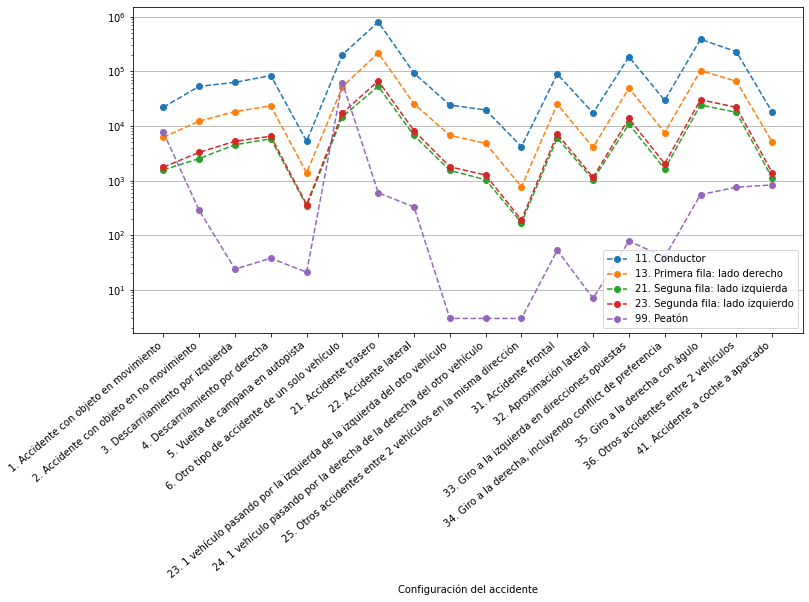

In [95]:
# Definimos nombres segunda variable
psn = ['11. Conductor',
       '13. Primera fila: lado derecho',
       '21. Seguna fila: lado izquierda',
       '23. Segunda fila: lado izquierdo',
       '99. Peatón']

# Seleccionamos los datos más relevantes
f = psn_conf.iloc[:,[0,2,3,5,12]]

# Visualizamos los datos
f.plot(logy=True,style='o--',figsize=(12,6))
plt.legend(psn)
plt.xlabel('Configuración del accidente')
plt.xticks(np.arange(0,18),conf,rotation=40,ha='right')
plt.grid(axis='y');

## 13. Dispositivo de seguridad y severidad del accidente

El porcentage de mortalidad es superior en accidentes donde no se usa dispositivos de seguridad, una clara evidencia para usarlos. Se observa que con chaleco reflectante el número de accidentes mortales es muy bajo o casi inexistente, gracias a la visivilidad que ofrece a los conductores.

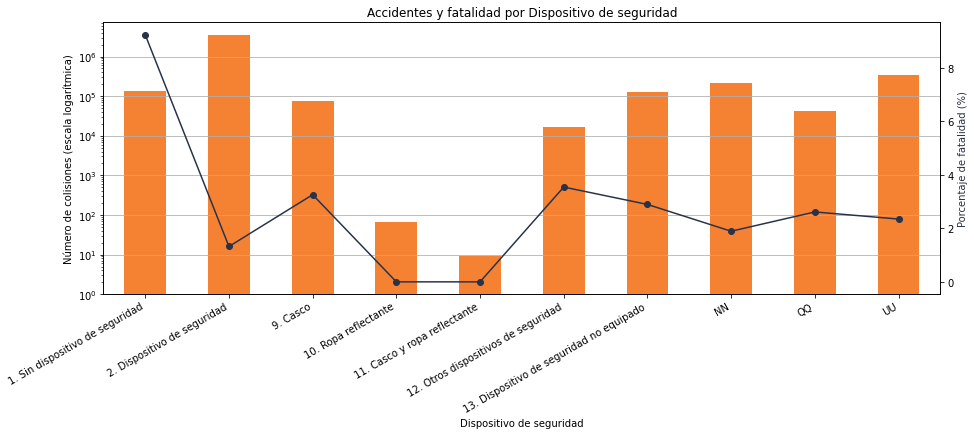

In [50]:
safety = ['1. Sin dispositivo de seguridad',
          '2. Dispositivo de seguridad',
          '9. Casco',
          '10. Ropa reflectante',
          '11. Casco y ropa reflectante',
          '12. Otros dispositivos de seguridad',
          '13. Dispositivo de seguridad no equipado',
          'NN', 'QQ', 'UU']
barplot_fatality(df_2, 'p_safe', 'Dispositivo de seguridad', safety)